In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import warnings
import time
import math

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False
# 한글 폰트 설정
plt.rcParams['font.family'] = "NanumGothic"

warnings.filterwarnings('ignore')

data_dir = 'data'

df = pd.read_csv("./input_df.csv")
df

value   
0                                  반려동물의 종류에 대해서 알고 계신가요?  \
1                                                      네.   
2                                                알고 있습니다.   
3       보통 요즘 현대인들이 많이 키우는 반려동물은 개 고양이 위주로 많이 키우는데 그 외...   
4       저도 기회가 된다면 나중에는 고슴도치 같은 걸 키워보고 싶기도 하고 제 주위에 뱀을...   
...                                                   ...   
176822     아무래도 영상학과고 서로 협업해야 하는 과제가 많기 때문에 그런 경우가 있었는데요.   
176823  보통 선배들과 후배들이 친해지는 경우가 꽤 있고 그런 경우에는 선배가 후배에게 그 ...   
176824  아니면 과제가 많다 적다 아니면 시험은 이런 식으로 내신다 이런 식의 선배들이 도움...   
176825  후배들은 선배가 취업 활동을 진행할 때 그에 다른 도움을 주거나 그~ 그런 식으로 ...   
176826  대학교에는 다양한 장학금 제도가 진행되고 있다고 들었는데 장학금은 꼭 학점이 높은 ...   

                                                    label  
0                                                      네.  
1                                                알고 있습니다.  
2       보통 요즘 현대인들이 많이 키우는 반려동물은 개 고양이 위주로 많이 키우는데 그 외...  
3       저도 기회가 된다면 나중에는 고슴도치 같은 걸 키워보고 싶기도 하고 제 주위에 뱀을...  
4                                        키우는 반려동물이 있으신가요?  
...                                                   ...  
176822  보통 선배들과 후배들이 친해지는 경우가 꽤 있고 그런 경우에는 선배가 후배에게 그 ...  
176823  아니면 과제가 많다 적다 아니면 시험은 이런 식으로 내신다 이런 식의 선배들이 도움...  
176824  후배들은 선배가 취업 활동을 진행할 때 그에 다른 도움을 주거나 그~ 그런 식으로 ...  
176825  대학교에는 다양한 장학금 제도가 진행되고 있다고 들었는데 장학금은 꼭 학점이 높은 ...  
176826                                          그렇지는 않아요.  

[176827 rows x 2 columns]

In [3]:
question = df['value']
answer = df['label']

데이터 전처리

In [4]:
#한글 정규화
import re

# 한글, 영어, 숫자, 공백, ?!.,을 제외한 나머지 문자 제거
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 패턴 컴파일
normalizer = re.compile(korean_pattern)
normalizer

re.compile(r'[^ ?,.!A-Za-z0-9가-힣+]', re.UNICODE)

In [5]:
def normalize(sentence):
    return normalizer.sub("", sentence)

normalize(question[10])

'이렇게 동물 반려동물과 같이 사니까 반려동물이 주는 행복감도 있고 또 그 안에서 제가 배울 점도 몇 가지 생기고 책임져야 할 것이 있으니까 조금 더 노력하게 되고 그렇게 되는 거 같습니다.'

In [6]:
from konlpy.tag import Okt

# 형태소 분석기

okt = Okt()

In [7]:
# okt
okt.morphs(normalize(answer[10]))

['연예인', '들', '의', '이색', '반려견', '에', '대해', '서', '어떻게', '아시나요', '?']

In [8]:
# 한글 전처리를 함수화
def clean_text(sentence, tagger):
    sentence = normalize(sentence)
    sentence = tagger.morphs(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    return sentence

In [9]:
clean_text(question[10], okt)

'이렇게 동물 반려동물 과 같이 사 니까 반려동물 이 주는 행복감 도 있고 또 그 안 에서 제 가 배울 점도 몇 가지 생기 고 책임져야 할 것 이 있으니까 조금 더 노력 하게 되고 그렇게 되는 거 같습니다 .'

In [10]:
clean_text(answer[10], okt)

'연예인 들 의 이색 반려견 에 대해 서 어떻게 아시나요 ?'

In [11]:
len(question), len(answer)

(176827, 176827)

In [12]:
questions = [clean_text(sent, okt) for sent in question.values]
answers = [clean_text(sent, okt) for sent in answer.values]

In [13]:
len(questions), len(answers)

(176827, 176827)

In [14]:
#단어 사전 생성
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
class WordVocab():
    def __init__(self):
        SOS_TOKEN = 0
        EOS_TOKEN = 1
        UNKNOWN_TOKEN = 2
        
        self.unknown_token = UNKNOWN_TOKEN
        
        # 각 토큰 별 word count
        self.word2count = {}
        
        # word -> idx
        self.word2index = {
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
            '<UKN>': UNKNOWN_TOKEN,
        }

        # idx -> word
        self.index2word = {
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>', 
            UNKNOWN_TOKEN: '<UKN>',
        }
        
        # total word counts
        self.n_words = 3  # SOS, EOS, UNKNOWN 포함

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word_to_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return self.unknown_token
    
    def index_to_word(self, idx):
        return self.index2word[idx]

In [16]:
print(f'원문: {questions[10]}')
wordvocab = WordVocab()
wordvocab.add_sentence(questions[10])
print('==='*10)
print('단어사전')
print(wordvocab.word2index)

원문: 이렇게 동물 반려동물 과 같이 사 니까 반려동물 이 주는 행복감 도 있고 또 그 안 에서 제 가 배울 점도 몇 가지 생기 고 책임져야 할 것 이 있으니까 조금 더 노력 하게 되고 그렇게 되는 거 같습니다 .
단어사전
{'<SOS>': 0, '<EOS>': 1, '<UKN>': 2, '이렇게': 3, '동물': 4, '반려동물': 5, '과': 6, '같이': 7, '사': 8, '니까': 9, '이': 10, '주는': 11, '행복감': 12, '도': 13, '있고': 14, '또': 15, '그': 16, '안': 17, '에서': 18, '제': 19, '가': 20, '배울': 21, '점도': 22, '몇': 23, '가지': 24, '생기': 25, '고': 26, '책임져야': 27, '할': 28, '것': 29, '있으니까': 30, '조금': 31, '더': 32, '노력': 33, '하게': 34, '되고': 35, '그렇게': 36, '되는': 37, '거': 38, '같습니다': 39, '.': 40}


In [17]:
#전처리 프로세스를 클레스화 - 데이터 로드, 전처리, 사전 생성, 시퀀스 변환
from konlpy.tag import Okt


class QADataset():
    def __init__(self, csv_path, min_length=1, max_length=647):
        data_dir = 'data'
        
        # TOKEN 정의
        self.SOS_TOKEN = 0 # SOS 토큰
        self.EOS_TOKEN = 1 # EOS 토큰
        
        self.tagger = Okt()   # 형태소 분석기
        self.max_length = max_length # 한 문장의 최대 길이 지정
        
        # CSV 데이터 로드
        df = pd.read_csv(csv_path)
        
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, tgt: 답변
        src_clean = []
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        
        for _, row in df.iterrows():
            src = row['value']
            tgt = row['label']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)
                tgt_clean.append(tgt)            
        
        self.srcs = src_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab

    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(sentence)
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        sequences = [self.wordvocab.word_to_index(w) for w in sentence.split()]
        # 문장 최대 길이 -1 까지 슬라이싱
        sequences = sequences[:self.max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
        sequences.append(self.EOS_TOKEN)
        return sequences
    
    def sequences_to_texts(self, sequences):
        # 시퀀스 -> 문장으로 변환
        sentences = [self.wordvocab.index_to_word(s.item()) for s in sequences]
        return ' '.join(sentences)

    
    def __getitem__(self, idx):
        inputs = self.srcs[idx]
        inputs_sequences = self.texts_to_sequences(inputs)
        
        outputs = self.tgts[idx]
        outputs_sequences = self.texts_to_sequences(outputs)
        
        return torch.tensor(inputs_sequences).view(-1, 1), torch.tensor(outputs_sequences).view(-1, 1)
    
    def __len__(self):
        return len(self.srcs)

In [18]:
MAX_LENGTH = 647

dataset = QADataset('./input_df.csv', min_length=1, max_length=MAX_LENGTH)

In [19]:
x, y = dataset[3]

# 시퀀스를 문장으로 변환
print(dataset.sequences_to_texts(x))
print(dataset.sequences_to_texts(y))

보통 요즘 현대인 들 이 많이 키우는 반려동물 은 개 고양이 위주 로 많이 키우는데 그 외 에도 요즘 에 이 이색 적 이 게 침팬지 햄스터 혹은 작은 미니 피그 같은 동물 도 많이 키우고 있 있다고 들었습니다 . <EOS>
저 도 기회 가 된다면 나중 에는 고슴도치 같은 걸 키워 보고 싶기도 하고 제 주위 에 뱀 을 뱀 이나 도마뱀 같은 것 을 키우는 사람 도 많고 현재 는 많은 많이 다양해진 반려동물 을 볼 수 있다고 생각 을 하고 있습니다 . <EOS>


Encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False, 
                          batch_first=True,
                         )
    def init_weights(self):
        initrange = 1
        self.gru.weight.data.uniform_ = (-initrange, initrange)
        
    def forward(self, x, hidden):
        # (sequence_length, 1)
        x = self.embedding(x).view(1, 1, -1)
        # x: (1, 1, embedding_dim)
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        output, hidden = self.gru(x, hidden)
        # output: (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return output, hidden
    
    def init_hidden(self, device):
        # hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32)) 로 초기화
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
NUM_VOCABS = dataset.wordvocab.n_words
print(f'number of vocabs: {NUM_VOCABS}')

number of vocabs: 89168


In [22]:
#encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=32, 
                  embedding_dim=20, 
                  num_layers=1)

In [23]:
# Encoder hidden_state 초기화
encoder.init_hidden(device=device).shape

torch.Size([1, 1, 32])

In [24]:
# Encoder에 x 통과 후 output, hidden_size 의 shape 확인
encoder_out, encoder_hidden = encoder(x[0], torch.zeros_like(encoder.init_hidden(device='cpu')))

print(encoder_out.shape)
print(encoder_hidden.shape)
# output      : (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
# hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 1, 32])
torch.Size([1, 1, 32])


Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers=1):
        super(Decoder, self).__init__()
        # 단어사전 개수
        self.num_vocabs = num_vocabs
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False)
        # 최종 출력은 단어사전의 개수
        self.fc = nn.Linear(hidden_size, num_vocabs)
    
    def init_weights(self):
        initrange = 1
        self.gru.weight.data.uniform_ = (-initrange, initrange)
        self.gru.bias.data.zero_()
        
    def forward(self, x, hidden_state):
        x = self.embedding(x) # (H): 1개의 word에 대한 h
        x = x.view(1, 1, -1) # (1, 1, H) 로 변환
        embedded = F.relu()
        output, hidden = self.gru(embedded, hidden_state)
        output = self.fc(output.squeeze(0)) # (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
        return output, hidden

In [26]:
x = torch.abs(torch.randn(size=(10, 1)).long())
print(x.shape)
# (디코더의 sequence_length, 1)

torch.Size([10, 1])


In [27]:
#임베딩 layer
embedding_dim = 20 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

embedded = embedding(x[0])
# 디코더의 1개 토큰에 대한 임베딩 차원
# (1, embedding_dim)
print(embedded.shape)
embedded = embedded.view(1, 1, -1)
# (1, 1, embedding_dim)
print(embedded.shape)

torch.Size([1, 20])
torch.Size([1, 1, 20])


In [28]:
#GRU layer 입출력
embedding_dim = 20 # 임베딩 차원
hidden_size = 32

gru = nn.GRU(embedding_dim, 
             hidden_size, 
             num_layers=1, 
             bidirectional=False)

decoder_out, decoder_hidden = gru(embedded)

print(decoder_out.shape)
# decoder_out: (sequence_length, batch_size, hidden_size(32) x bidirectional(1))
print(decoder_hidden.shape)
# decoder_hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))

torch.Size([1, 1, 32])
torch.Size([1, 1, 32])


In [29]:
#출력층
fc = nn.Linear(32, NUM_VOCABS) # 출력은 단어사전의 개수로 가정

output = fc(decoder_out[0])

print(decoder_out[0].shape)
print(output.shape)
# input : (batch_size, hidden_size)
# output: (batch_size, output dimension(number of vocabs))

torch.Size([1, 32])
torch.Size([1, 89168])


attention이 적용된 Decoder

In [30]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim , max_length)
        self.attn_combine = nn.Linear(hidden_size + embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_vocabs)

    def forward(self, x, hidden, encoder_outputs):
        # x: (1, 1) 1개의 토큰
        embedded = self.embedding(x).view(1, 1, -1)
        # embedded: (1, 1, 1)
        embedded = self.dropout(embedded)

        
        # embedded[0]: (1, embedding_dim)
        # hidden[0]: (1, hidden_size)
        attn_in = torch.cat((embedded[0], hidden[0]), 1)
        # attn_in: (1, embedding_dim + hidden_size)
                            
        attn = self.attn(attn_in)
        # attn: (1, max_length)
                         
        attn_weights = F.softmax(attn)
        # attn_weights: (1, max_length)
        
        # (1, 1, max_length), (1, max_length, hidden_size)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # attn_applied: (1, 1, hidden_size)

        # embedded[0]: (1, embedding_dim)
        # attn_applied[0]: (1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output: (1, embedding_dim + hidden_size)
        
        output = self.attn_combine(output)
        # output: (1, hidden_size)
        output = output.unsqueeze(0)
        # output: (1, 1, hidden_size)

        output = F.relu(output)
        # output: (1, 1, hidden_size)
        
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        output, hidden = self.gru(output, hidden)
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        
        # output[0]: (1, hidden_size)
        output = self.out(output[0])
        # output: (1, number of vocabs)
        
        # output[0]: (number of vocabs)
        # hidden: (1, 1, hidden_size)
        # attn_weights: (1, max_length)
        return output[0], hidden, attn_weights

    def initHidden(self, device):
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [31]:
# 디코더 문장의 길이가 12 단어라고 가정한 경우
x = torch.abs(torch.randn(size=(12, 1)).long())
x.shape

torch.Size([12, 1])

디코더 1개에 대한 임베딩

In [32]:
embedding_dim = 20
embedding = nn.Embedding(wordvocab.n_words, embedding_dim)

# Decoder의 단어 1개: x[0]를 입력으로 가짐
embedded = embedding(x[0])
print(embedded.shape)
# (1, 20)

embedded = embedded.view(1, 1, -1)
# (1, 1, 20)
print(embedded.shape)

torch.Size([1, 20])
torch.Size([1, 1, 20])


In [33]:
# dropout 적용
dropout = nn.Dropout(0.1)
embedded = dropout(embedded)
embedded.shape

torch.Size([1, 1, 20])

-디코더의 첫 번째 단어는 Encoder hidden_state를 사용

-두 번째 단어부터는 이전 단계의 Decoder hidden_state를 사용

-디코드의 현재 입력 Embedding + (Encoder hidden_state or Decoder 

-이전 단계의 hidden_state)를 concat

-결과는 (1, E + H)

In [34]:
# 첫 단어는 encoder_hidden 사용, 두 번째 단어부터는 decoder_hidden 사용
# encoder_hidden.shape == decoder_hidden.shape 같아야 함
# hidden.shape: (1, 1, H)
hidden = encoder_hidden
print(hidden[0].shape)
print(embedded[0].shape)

torch.Size([1, 32])
torch.Size([1, 20])


In [35]:
# 디코드의 현재 입력 Embedding + (Encoder hidden_state or Decoder 이전 단계의 hidden_state)를 concat
context = torch.cat((embedded[0], hidden[0]), 1)
context.shape

torch.Size([1, 52])

-attention 생성

-FC 레이어: (1, E+H) -> (1, MAX_LENGTH)

In [36]:
# (1, E+H) -> (1, MAX_LENGTH)
fc = nn.Linear(hidden_size+embedding_dim, MAX_LENGTH)
attn = fc(context)
print(attn.shape)

torch.Size([1, 647])


In [37]:
attn_weights = F.softmax(attn, dim=1)
# attn weights: (1, MAX_LENGTH)
print('변경 전:', attn_weights.shape)
# (1, MAX_LENGTH) -> (1, 1, MAX_LENGTH)
attn_weights = attn_weights.unsqueeze(0)
print('변경 후:', attn_weights.shape)

변경 전: torch.Size([1, 647])
변경 후: torch.Size([1, 1, 647])


In [38]:
# Encoder의 시퀀스 별 H가 모두 채워진 Matrix
encoder_outputs = torch.zeros(MAX_LENGTH, hidden_size)
# (MAX_LENGTH, H)
print('변경 전:', encoder_outputs.shape)
encoder_outputs = encoder_outputs.unsqueeze(0)
# (1, MAX_LENGTH, H)
print('변경 후', encoder_outputs.shape)

변경 전: torch.Size([647, 32])
변경 후 torch.Size([1, 647, 32])


attention weights: 현재의 디코더 입력 (1개 단어)와 이전 단계의hidden_state 사이에서 구한 Energy

encoder outputs: 인코더의 전체 문장 출력 (MAX_LENGTH, hidden_size)로 이루어짐.

attention weights 와 encoder outputs 간의 Attention BMM을 산출

In [39]:
# BMM: (1, 1, MAX_LENGTH) x (1, MAX_LENGTH, H) => (1, 1, H)
# BMM 적용 후: (1, 1, H)
attn_applied = torch.bmm(attn_weights, encoder_outputs)
attn_applied.shape

torch.Size([1, 1, 32])

디코더의 현재 입력 (1개 단어)와 Attention 값을 concat

(1, E) + (1, H) = (1, E+H)

FC: (1, E+H) -> (1, H)

In [40]:
output = torch.cat((embedded[0], attn_applied[0]), 1)
# (1, E+H)
print('concat 결과 : ', output.shape)
fc = nn.Linear(hidden_size+embedding_dim, hidden_size)
output = fc(output)
# (1, H)
print('FC 통과 후   : ', output.shape)
# GRU 입력으로 넣기 위하여 (1, H) -> (1, 1, H)
output = output.unsqueeze(0)
print('unsqueeze 후: ', output.shape)

concat 결과 :  torch.Size([1, 52])
FC 통과 후   :  torch.Size([1, 32])
unsqueeze 후:  torch.Size([1, 1, 32])


output을 ReLU 통과

GRU의 입력으로 output, hidden 주입

output: (1, 1, H), hidden: (1, 1, H)

In [41]:
output = F.relu(output)
gru = nn.GRU(hidden_size, hidden_size)
output, hidden = gru(output, hidden)

In [42]:
output.shape, hidden.shape

(torch.Size([1, 1, 32]), torch.Size([1, 1, 32]))

output: (1, 1, 32) -> (1, 32)

output을 최종 출력으로 변경: (1, number of vocabs)

In [43]:
# (1, H) -> (1, number of vocabs)
out = nn.Linear(hidden_size, dataset.wordvocab.n_words)
decoder_out = out(output[0])
# (1, number of vocabs)
decoder_out.shape

torch.Size([1, 89168])

attention 디코더 입출력 확인

In [44]:
# 입력 문장의 길이가 12 단어라고 가정한 경우
# x: 12개의 토큰으로 이루어진 입력 문장이라고 가정
x = torch.abs(torch.randn(size=(12, 1)).long())
x.shape

torch.Size([12, 1])

In [45]:
encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size)
# (max_length, hidden_size)
encoder_outputs.shape

torch.Size([647, 32])

In [46]:
# (1, 1, hidden_size)
encoder_hidden.shape

torch.Size([1, 1, 32])

In [47]:
# Attention이 적용된 디코더 생성
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=32, 
                           embedding_dim=20, 
                           dropout_p=0.1, 
                           max_length=MAX_LENGTH)

In [48]:
# y[0]: 디코더의 입력으로 들어가는 1개 토큰
decoder_out, decoder_hidden, attn_weights = decoder(y[0], encoder_hidden, encoder_outputs)

In [49]:
# decoder_out: (number of vocabs)
# decoder_hidden: (1, 1, hidden_size)
# attn_weights: (1, max_length)
decoder_out.shape, decoder_hidden.shape, attn_weights.shape

(torch.Size([89168]), torch.Size([1, 1, 32]), torch.Size([1, 647]))

Training

In [50]:
SOS_TOKEN = dataset.SOS_TOKEN
EOS_TOKEN = dataset.EOS_TOKEN

In [51]:
# 훈련시 training loss 를 출력하기 위한 util 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Losses over training')
    plt.show()
    
# 훈련시 시간 출력을 위한 util 함수
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

# 훈련시 시간 출력을 위한 util 함수
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{as_minutes(s)} (remaining: {as_minutes(rs)})'

In [52]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, device, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    
    # Encoder의 hidden_state 초기화
    encoder_hidden = encoder.init_hidden(device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input_length: 입력 문장의 길이
    # target_length: 출력 문장의 길이
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder의 출력 결과를 담을 tensor
    # (문장의 max_length, encoder의 hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Encoder의 출력을 encoder_outputs[ei] 에 저장
        # encoder_output[0, 0]: (hidden_size,)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder의 첫 토큰은 SOS_TOKEN
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    # Encoder의 마지막 hidden state를 Decoder의 초기 hidden state로 지정
    decoder_hidden = encoder_hidden

    # teacher forcing 적용 여부 확률로 결정
    # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # loss 계산
        loss += criterion(decoder_output.view(1, -1), target_tensor[di])

        if use_teacher_forcing:
            # teacher forcing 적용: 정답 값 입력
            decoder_input = target_tensor[di]
        else:
            # 확률, 인덱스
            topv, topi = decoder_output.topk(1)
            # 다음 입력으로 주입할 디코더 최종 토큰 결정
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        # EOS_TOKEN 이면 종료
        if decoder_input.item() == EOS_TOKEN:
            break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [68]:
def train_iterations(encoder, decoder, n_iters, dataset, device, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate)
    
    encoder_scheduler = optim.lr_scheduler.StepLR(optimizer=encoder_optimizer,
                                            step_size=5.0,
                                            gamma=0.95,
                                            verbose=True)
    decoder_scheduler = optim.lr_scheduler.StepLR(optimizer=decoder_optimizer,
                                                 step_size=5.0,
                                                 gamma=0.95,
                                                 verbose=True)
    
    # 랜덤 샘플링된 데이터셋 생성
    training_pairs = [dataset[random.randint(0, len(dataset)-1)] for i in range(n_iters)]
    
    # Loss Function 정의
    criterion = nn.CrossEntropyLoss()

    # n_iters 만큼 training 시작
    for iter in range(1, n_iters + 1):
        # 문장 pair
        training_pair = training_pairs[iter - 1]        
        # 입력 문장
        input_tensor = training_pair[0]
        # 출력 문장
        target_tensor = training_pair[1]
        
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 훈련
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
                     decoder_optimizer, criterion, device)
        encoder_scheduler.step()
        decoder_scheduler.step()
        
        print_loss_total += loss
        plot_loss_total += loss

        # print_every 마다 loss 출력, 모델 저장
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start, iter/n_iters)} iter: {iter} ({iter/n_iters*100:.1f}%), loss: {print_loss_avg:.4f}')
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                }, "./model/Text2Text-se2se.pth")

            
        # plot_every 마다 loss 시각화
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        

    showPlot(plot_losses)

In [69]:
# Hyper-Parameter 정의
NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDING_DIM = 256
DROPOUT_P = 0.1

# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_layers=1)

# Attention 이 적용된 Decoder 정의
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=HIDDEN_SIZE, 
                           embedding_dim=EMBEDDING_DIM, 
                           dropout_p=DROPOUT_P, 
                           max_length=MAX_LENGTH)

# encoder, decoder 생성 및 device 지정
encoder = encoder.to(device)
decoder = decoder.to(device)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.5000e-04.


Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.4013e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 4.1812e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.
Adjusting learning rate of group 0 to 3.9721e-04.


Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.8403e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.
Adjusting learning rate of group 0 to 1.7482e-04.


Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.6945e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.
Adjusting learning rate of group 0 to 7.3098e-05.


Adjusting learning rate of group 0 to 3.3866e-05.
Adjusting learning rate of group 0 to 3.3866e-05.
Adjusting learning rate of group 0 to 3.3866e-05.
Adjusting learning rate of group 0 to 3.3866e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.2172e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.
Adjusting learning rate of group 0 to 3.0564e-05.


Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.4160e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.
Adjusting learning rate of group 0 to 1.3452e-05.


Adjusting learning rate of group 0 to 6.2321e-06.
Adjusting learning rate of group 0 to 6.2321e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
1m 7s (remaining: 222m 32s) iter: 500 (0.5%), loss: 5.9700
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.9205e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6245e-06.
Adjusting learning rate of group 0 to 5.6

Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.6058e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.4755e-06.
Adjusting learning rate of group 0 to 2.3517e-06.
Adjusting learning rate of group 0 to 2.3517e-06.
Adjusting learning rate of group 0 to 2.3517e-06.
Adjusting learning rate of group 0 to 2.3517e-06.


Adjusting learning rate of group 0 to 1.1469e-06.
Adjusting learning rate of group 0 to 1.1469e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0895e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.
Adjusting learning rate of group 0 to 1.0351e-06.


Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.7953e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.5555e-07.
Adjusting learning rate of group 0 to 4.3278e-07.
Adjusting learning rate of group 0 to 4.3278e-07.
Adjusting learning rate of group 0 to 4.3278e-07.
Adjusting learning rate of group 0 to 4.3278e-07.


Adjusting learning rate of group 0 to 2.1105e-07.
Adjusting learning rate of group 0 to 2.1105e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 2.0050e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.
Adjusting learning rate of group 0 to 1.9048e-07.


Adjusting learning rate of group 0 to 8.8246e-08.
Adjusting learning rate of group 0 to 8.8246e-08.
Adjusting learning rate of group 0 to 8.8246e-08.
Adjusting learning rate of group 0 to 8.8246e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 8.3834e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.
Adjusting learning rate of group 0 to 7.9642e-08.


Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.6898e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
2m 1s (remaining: 200m 50s) iter: 1000 (1.0%), loss: 5.7925
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.5053e-08.
Adjusting learning rate of group 0 to 3.3300e-08.
Adjusting learning rate of group 0 to 3.3300e-08.
Adjusting learning rate of group 0 to 3.

Adjusting learning rate of group 0 to 1.6240e-08.
Adjusting learning rate of group 0 to 1.6240e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.5428e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.
Adjusting learning rate of group 0 to 1.4656e-08.


Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.4506e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.
Adjusting learning rate of group 0 to 6.1281e-09.


Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.8391e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.6971e-09.
Adjusting learning rate of group 0 to 2.5623e-09.
Adjusting learning rate of group 0 to 2.5623e-09.
Adjusting learning rate of group 0 to 2.5623e-09.
Adjusting learning rate of group 0 to 2.5623e-09.


Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1871e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.1277e-09.
Adjusting learning rate of group 0 to 1.0713e-09.
Adjusting learning rate of group 0 to 1.0713e-09.


Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 5.2246e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.9634e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.
Adjusting learning rate of group 0 to 4.7152e-10.


Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.1845e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
3m 3s (remaining: 201m 12s) iter: 1500 (1.5%), loss: 5.7371
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 2.0753e-10.
Adjusting learning rate of group 0 to 1.9715e-10.
Adjusting learning rate of group 0 to 1.9715e-10.
Adjusting learning rate of group 0 to 1.9715e-10.
Adjusting learning rate of group 0 to 1.9715e-10.
Adjusting learning rate of group 0 to 1.9715e-10.
Adjusting learning rate of group 0 to 1.9715e-10.
Adjusting learning rate of group 0 to 1.

Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 9.1340e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.6773e-11.
Adjusting learning rate of group 0 to 8.2434e-11.
Adjusting learning rate of group 0 to 8.2434e-11.


Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.6924e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.4078e-13.
Adjusting learning rate of group 0 to 5.1374e-13.
Adjusting learning rate of group 0 to 5.1374e-13.


Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.5054e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.3801e-13.
Adjusting learning rate of group 0 to 2.2611e-13.
Adjusting learning rate of group 0 to 2.2611e-13.
Adjusting learning rate of group 0 to 2.2611e-13.
Adjusting learning rate of group 0 to 2.2611e-13.
Adjusting learning rate of group 0 to 2.2611e-13.
Adjusting learning rate of group 0 to 2.2611e-13.
Adjusting learning rate of group 0 to 2.2611e-13.
Adjusting learning rate of group 0 to 2.2611e-13.


Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 1.0476e-13.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.9517e-14.
Adjusting learning rate of group 0 to 9.4541e-14.
Adjusting learning rate of group 0 to 9.4541e-14.
Adjusting learning rate of group 0 to 9.4541e-14.
Adjusting learning rate of group 0 to 9.4541e-14.


Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.3800e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 4.1610e-14.
Adjusting learning rate of group 0 to 3.9530e-14.
Adjusting learning rate of group 0 to 3.9530e-14.
Adjusting learning rate of group 0 to 3.9530e-14.
Adjusting learning rate of group 0 to 3.9530e-14.


Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.8314e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.
Adjusting learning rate of group 0 to 1.7398e-14.


Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.6574e-15.
Adjusting learning rate of group 0 to 7.2745e-15.
Adjusting learning rate of group 0 to 7.2745e-15.
5m 4s (remaining: 198m 4s) iter: 2500 (2.5%), loss: 5.5715
Adjusting learning rate of group 0 to 7.2745e-15.
Adjusting learning rate of group 0 to 7.2745e-15.
Adjusting learning rate of group 0 to 7.2745e-15.
Adjusting learning rate of group 0 to 7.2745e-15.
Adjusting learning rate of group 0 to 7.2745e-15.
Adjusting learning rate of group 0 to 7.2745e-15.
Adjusting learning rate of group 0 to 7.2

Adjusting learning rate of group 0 to 3.3702e-15.
Adjusting learning rate of group 0 to 3.3702e-15.
Adjusting learning rate of group 0 to 3.3702e-15.
Adjusting learning rate of group 0 to 3.3702e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.2017e-15.
Adjusting learning rate of group 0 to 3.0416e-15.
Adjusting learning rate of group 0 to 3.0416e-15.
Adjusting learning rate of group 0 to 3.0416e-15.
Adjusting learning rate of group 0 to 3.0416e-15.
Adjusting learning rate of group 0 to 3.0416e-15.
Adjusting learning rate of group 0 to 3.0416e-15.


Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.4092e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.3387e-15.
Adjusting learning rate of group 0 to 1.2718e-15.
Adjusting learning rate of group 0 to 1.2718e-15.


Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 6.2021e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.8920e-16.
Adjusting learning rate of group 0 to 5.5974e-16.
Adjusting learning rate of group 0 to 5.5974e-16.
Adjusting learning rate of group 0 to 5.5974e-16.
Adjusting learning rate of group 0 to 5.5974e-16.
Adjusting learning rate of group 0 to 5.5974e-16.
Adjusting learning rate of group 0 to 5.5974e-16.
Adjusting learning rate of group 0 to 5.5974e-16.
Adjusting learning rate of group 0 to 5.5974e-16.


Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.5932e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.4635e-16.
Adjusting learning rate of group 0 to 2.3404e-16.
Adjusting learning rate of group 0 to 2.3404e-16.


Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0843e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 1.0301e-16.
Adjusting learning rate of group 0 to 9.7856e-17.
Adjusting learning rate of group 0 to 9.7856e-17.


Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.7722e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.5336e-17.
Adjusting learning rate of group 0 to 4.3069e-17.
Adjusting learning rate of group 0 to 4.3069e-17.
6m 7s (remaining: 198m 12s) iter: 3000 (3.0%), loss: 5.7522
Adjusting learning rate of group 0 to 4.3069e-17.
Adjusting learning rate of group 0 to 4.3069e-17.
Adjusting learning rate of group 0 to 4.

Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.9953e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8956e-17.
Adjusting learning rate of group 0 to 1.8008e-17.
Adjusting learning rate of group 0 to 1.8008e-17.
Adjusting learning rate of group 0 to 1.8008e-17.
Adjusting learning rate of group 0 to 1.8008e-17.


Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 8.3429e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.9258e-18.
Adjusting learning rate of group 0 to 7.5295e-18.
Adjusting learning rate of group 0 to 7.5295e-18.


Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.4883e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.
Adjusting learning rate of group 0 to 3.3139e-18.


Adjusting learning rate of group 0 to 1.5353e-18.
Adjusting learning rate of group 0 to 1.5353e-18.
Adjusting learning rate of group 0 to 1.5353e-18.
Adjusting learning rate of group 0 to 1.5353e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.4585e-18.
Adjusting learning rate of group 0 to 1.3856e-18.
Adjusting learning rate of group 0 to 1.3856e-18.
Adjusting learning rate of group 0 to 1.3856e-18.
Adjusting learning rate of group 0 to 1.3856e-18.
Adjusting learning rate of group 0 to 1.3856e-18.
Adjusting learning rate of group 0 to 1.3856e-18.


Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.4195e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 6.0985e-19.
Adjusting learning rate of group 0 to 5.7936e-19.
Adjusting learning rate of group 0 to 5.7936e-19.


Adjusting learning rate of group 0 to 2.8254e-19.
Adjusting learning rate of group 0 to 2.8254e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.6841e-19.
Adjusting learning rate of group 0 to 2.5499e-19.
Adjusting learning rate of group 0 to 2.5499e-19.
7m 6s (remaining: 196m 12s) iter: 3500 (3.5%), loss: 5.5152
Adjusting learning rate of group 0 to 2.5499e-19.
Adjusting learning rate of group 0 to 2.5499e-19.
Adjusting learning rate of group 0 to 2.5499e-19.
Adjusting learning rate of group 0 to 2.5499e-19.
Adjusting learning rate of group 0 to 2.

Adjusting learning rate of group 0 to 1.1813e-19.
Adjusting learning rate of group 0 to 1.1813e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.1223e-19.
Adjusting learning rate of group 0 to 1.0662e-19.
Adjusting learning rate of group 0 to 1.0662e-19.
Adjusting learning rate of group 0 to 1.0662e-19.
Adjusting learning rate of group 0 to 1.0662e-19.
Adjusting learning rate of group 0 to 1.0662e-19.
Adjusting learning rate of group 0 to 1.0662e-19.
Adjusting learning rate of group 0 to 1.0662e-19.
Adjusting learning rate of group 0 to 1.0662e-19.


Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.9395e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.6925e-20.
Adjusting learning rate of group 0 to 4.4579e-20.
Adjusting learning rate of group 0 to 4.4579e-20.


Adjusting learning rate of group 0 to 2.1740e-20.
Adjusting learning rate of group 0 to 2.1740e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 2.0653e-20.
Adjusting learning rate of group 0 to 1.9620e-20.
Adjusting learning rate of group 0 to 1.9620e-20.
Adjusting learning rate of group 0 to 1.9620e-20.
Adjusting learning rate of group 0 to 1.9620e-20.
Adjusting learning rate of group 0 to 1.9620e-20.
Adjusting learning rate of group 0 to 1.9620e-20.
Adjusting learning rate of group 0 to 1.9620e-20.
Adjusting learning rate of group 0 to 1.9620e-20.


Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 9.0899e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.6354e-21.
Adjusting learning rate of group 0 to 8.2036e-21.
Adjusting learning rate of group 0 to 8.2036e-21.


Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 4.0007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.8007e-21.
Adjusting learning rate of group 0 to 3.6106e-21.
Adjusting learning rate of group 0 to 3.6106e-21.
Adjusting learning rate of group 0 to 3.6106e-21.
Adjusting learning rate of group 0 to 3.6106e-21.
Adjusting learning rate of group 0 to 3.6106e-21.
Adjusting learning rate of group 0 to 3.6106e-21.


Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.6728e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5891e-21.
Adjusting learning rate of group 0 to 1.5097e-21.
Adjusting learning rate of group 0 to 1.5097e-21.


Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.9942e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.
Adjusting learning rate of group 0 to 6.6445e-22.


Adjusting learning rate of group 0 to 3.0783e-22.
Adjusting learning rate of group 0 to 3.0783e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.9244e-22.
Adjusting learning rate of group 0 to 2.7782e-22.
Adjusting learning rate of group 0 to 2.7782e-22.
Adjusting learning rate of group 0 to 2.7782e-22.
Adjusting learning rate of group 0 to 2.7782e-22.
Adjusting learning rate of group 0 to 2.7782e-22.
Adjusting learning rate of group 0 to 2.7782e-22.
Adjusting learning rate of group 0 to 2.7782e-22.
Adjusting learning rate of group 0 to 2.7782e-22.


Adjusting learning rate of group 0 to 1.2871e-22.
Adjusting learning rate of group 0 to 1.2871e-22.
Adjusting learning rate of group 0 to 1.2871e-22.
Adjusting learning rate of group 0 to 1.2871e-22.
Adjusting learning rate of group 0 to 1.2871e-22.
Adjusting learning rate of group 0 to 1.2871e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.2228e-22.
Adjusting learning rate of group 0 to 1.1616e-22.
Adjusting learning rate of group 0 to 1.1616e-22.
Adjusting learning rate of group 0 to 1.1616e-22.
Adjusting learning rate of group 0 to 1.1616e-22.


Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.3817e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.
Adjusting learning rate of group 0 to 5.1126e-23.


Adjusting learning rate of group 0 to 2.3686e-23.
Adjusting learning rate of group 0 to 2.3686e-23.
Adjusting learning rate of group 0 to 2.3686e-23.
Adjusting learning rate of group 0 to 2.3686e-23.
Adjusting learning rate of group 0 to 2.3686e-23.
Adjusting learning rate of group 0 to 2.3686e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.2502e-23.
Adjusting learning rate of group 0 to 2.1377e-23.
Adjusting learning rate of group 0 to 2.1377e-23.
Adjusting learning rate of group 0 to 2.1377e-23.
Adjusting learning rate of group 0 to 2.1377e-23.


Adjusting learning rate of group 0 to 1.0425e-23.
Adjusting learning rate of group 0 to 1.0425e-23.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.9037e-24.
Adjusting learning rate of group 0 to 9.4085e-24.
Adjusting learning rate of group 0 to 9.4085e-24.
Adjusting learning rate of group 0 to 9.4085e-24.
Adjusting learning rate of group 0 to 9.4085e-24.
Adjusting learning rate of group 0 to 9.4085e-24.
Adjusting learning rate of group 0 to 9.4085e-24.
Adjusting learning rate of group 0 to 9.4085e-24.
Adjusting learning rate of group 0 to 9.4085e-24.


Adjusting learning rate of group 0 to 4.3589e-24.
Adjusting learning rate of group 0 to 4.3589e-24.
Adjusting learning rate of group 0 to 4.3589e-24.
Adjusting learning rate of group 0 to 4.3589e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 4.1409e-24.
Adjusting learning rate of group 0 to 3.9339e-24.
Adjusting learning rate of group 0 to 3.9339e-24.
Adjusting learning rate of group 0 to 3.9339e-24.
Adjusting learning rate of group 0 to 3.9339e-24.
Adjusting learning rate of group 0 to 3.9339e-24.
Adjusting learning rate of group 0 to 3.9339e-24.


Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.8225e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.7314e-24.
Adjusting learning rate of group 0 to 1.6448e-24.
Adjusting learning rate of group 0 to 1.6448e-24.


Adjusting learning rate of group 0 to 8.0215e-25.
Adjusting learning rate of group 0 to 8.0215e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.6204e-25.
Adjusting learning rate of group 0 to 7.2394e-25.
Adjusting learning rate of group 0 to 7.2394e-25.
Adjusting learning rate of group 0 to 7.2394e-25.
Adjusting learning rate of group 0 to 7.2394e-25.
Adjusting learning rate of group 0 to 7.2394e-25.
Adjusting learning rate of group 0 to 7.2394e-25.
Adjusting learning rate of group 0 to 7.2394e-25.
Adjusting learning rate of group 0 to 7.2394e-25.


Adjusting learning rate of group 0 to 3.3539e-25.
Adjusting learning rate of group 0 to 3.3539e-25.
Adjusting learning rate of group 0 to 3.3539e-25.
Adjusting learning rate of group 0 to 3.3539e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.1862e-25.
Adjusting learning rate of group 0 to 3.0269e-25.
Adjusting learning rate of group 0 to 3.0269e-25.
Adjusting learning rate of group 0 to 3.0269e-25.
Adjusting learning rate of group 0 to 3.0269e-25.
Adjusting learning rate of group 0 to 3.0269e-25.
Adjusting learning rate of group 0 to 3.0269e-25.


Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.4024e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.3322e-25.
Adjusting learning rate of group 0 to 1.2656e-25.
Adjusting learning rate of group 0 to 1.2656e-25.


Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.8635e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.
Adjusting learning rate of group 0 to 5.5703e-26.


Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.4517e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.
Adjusting learning rate of group 0 to 2.3291e-26.


Adjusting learning rate of group 0 to 1.0790e-26.
Adjusting learning rate of group 0 to 1.0790e-26.
Adjusting learning rate of group 0 to 1.0790e-26.
Adjusting learning rate of group 0 to 1.0790e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 1.0251e-26.
Adjusting learning rate of group 0 to 9.7383e-27.
Adjusting learning rate of group 0 to 9.7383e-27.
Adjusting learning rate of group 0 to 9.7383e-27.
Adjusting learning rate of group 0 to 9.7383e-27.
Adjusting learning rate of group 0 to 9.7383e-27.
Adjusting learning rate of group 0 to 9.7383e-27.


Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.5117e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.2861e-27.
Adjusting learning rate of group 0 to 4.0718e-27.
Adjusting learning rate of group 0 to 4.0718e-27.


Adjusting learning rate of group 0 to 1.9857e-27.
Adjusting learning rate of group 0 to 1.9857e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.8864e-27.
Adjusting learning rate of group 0 to 1.7921e-27.
Adjusting learning rate of group 0 to 1.7921e-27.
Adjusting learning rate of group 0 to 1.7921e-27.
Adjusting learning rate of group 0 to 1.7921e-27.
Adjusting learning rate of group 0 to 1.7921e-27.
Adjusting learning rate of group 0 to 1.7921e-27.
Adjusting learning rate of group 0 to 1.7921e-27.
Adjusting learning rate of group 0 to 1.7921e-27.


Adjusting learning rate of group 0 to 8.3027e-28.
Adjusting learning rate of group 0 to 8.3027e-28.
Adjusting learning rate of group 0 to 8.3027e-28.
Adjusting learning rate of group 0 to 8.3027e-28.
Adjusting learning rate of group 0 to 8.3027e-28.
Adjusting learning rate of group 0 to 8.3027e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.8875e-28.
Adjusting learning rate of group 0 to 7.4932e-28.
Adjusting learning rate of group 0 to 7.4932e-28.
Adjusting learning rate of group 0 to 7.4932e-28.
Adjusting learning rate of group 0 to 7.4932e-28.


Adjusting learning rate of group 0 to 3.6542e-28.
Adjusting learning rate of group 0 to 3.6542e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.4715e-28.
Adjusting learning rate of group 0 to 3.2979e-28.
Adjusting learning rate of group 0 to 3.2979e-28.
Adjusting learning rate of group 0 to 3.2979e-28.
Adjusting learning rate of group 0 to 3.2979e-28.
Adjusting learning rate of group 0 to 3.2979e-28.
Adjusting learning rate of group 0 to 3.2979e-28.
Adjusting learning rate of group 0 to 3.2979e-28.
Adjusting learning rate of group 0 to 3.2979e-28.


Adjusting learning rate of group 0 to 1.5279e-28.
Adjusting learning rate of group 0 to 1.5279e-28.
Adjusting learning rate of group 0 to 1.5279e-28.
Adjusting learning rate of group 0 to 1.5279e-28.
Adjusting learning rate of group 0 to 1.5279e-28.
Adjusting learning rate of group 0 to 1.5279e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.4515e-28.
Adjusting learning rate of group 0 to 1.3789e-28.
Adjusting learning rate of group 0 to 1.3789e-28.
Adjusting learning rate of group 0 to 1.3789e-28.
Adjusting learning rate of group 0 to 1.3789e-28.


Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.3885e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 6.0691e-29.
Adjusting learning rate of group 0 to 5.7656e-29.
Adjusting learning rate of group 0 to 5.7656e-29.


Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.6712e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.
Adjusting learning rate of group 0 to 2.5376e-29.


Adjusting learning rate of group 0 to 1.1756e-29.
Adjusting learning rate of group 0 to 1.1756e-29.
Adjusting learning rate of group 0 to 1.1756e-29.
Adjusting learning rate of group 0 to 1.1756e-29.
Adjusting learning rate of group 0 to 1.1756e-29.
Adjusting learning rate of group 0 to 1.1756e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.1169e-29.
Adjusting learning rate of group 0 to 1.0610e-29.
Adjusting learning rate of group 0 to 1.0610e-29.
Adjusting learning rate of group 0 to 1.0610e-29.
Adjusting learning rate of group 0 to 1.0610e-29.


Adjusting learning rate of group 0 to 5.1743e-30.
Adjusting learning rate of group 0 to 5.1743e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.9156e-30.
Adjusting learning rate of group 0 to 4.6698e-30.
Adjusting learning rate of group 0 to 4.6698e-30.
Adjusting learning rate of group 0 to 4.6698e-30.
Adjusting learning rate of group 0 to 4.6698e-30.
Adjusting learning rate of group 0 to 4.6698e-30.
Adjusting learning rate of group 0 to 4.6698e-30.
Adjusting learning rate of group 0 to 4.6698e-30.
Adjusting learning rate of group 0 to 4.6698e-30.


Adjusting learning rate of group 0 to 2.1635e-30.
Adjusting learning rate of group 0 to 2.1635e-30.
Adjusting learning rate of group 0 to 2.1635e-30.
Adjusting learning rate of group 0 to 2.1635e-30.
Adjusting learning rate of group 0 to 2.1635e-30.
Adjusting learning rate of group 0 to 2.1635e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 2.0553e-30.
Adjusting learning rate of group 0 to 1.9526e-30.
Adjusting learning rate of group 0 to 1.9526e-30.
Adjusting learning rate of group 0 to 1.9526e-30.
Adjusting learning rate of group 0 to 1.9526e-30.


Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 9.0460e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.
Adjusting learning rate of group 0 to 8.5937e-31.


Adjusting learning rate of group 0 to 3.9814e-31.
Adjusting learning rate of group 0 to 3.9814e-31.
Adjusting learning rate of group 0 to 3.9814e-31.
Adjusting learning rate of group 0 to 3.9814e-31.
Adjusting learning rate of group 0 to 3.9814e-31.
Adjusting learning rate of group 0 to 3.9814e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.7823e-31.
Adjusting learning rate of group 0 to 3.5932e-31.
Adjusting learning rate of group 0 to 3.5932e-31.
Adjusting learning rate of group 0 to 3.5932e-31.
Adjusting learning rate of group 0 to 3.5932e-31.


Adjusting learning rate of group 0 to 1.7523e-31.
Adjusting learning rate of group 0 to 1.7523e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.6647e-31.
Adjusting learning rate of group 0 to 1.5815e-31.
Adjusting learning rate of group 0 to 1.5815e-31.
Adjusting learning rate of group 0 to 1.5815e-31.
Adjusting learning rate of group 0 to 1.5815e-31.
Adjusting learning rate of group 0 to 1.5815e-31.
Adjusting learning rate of group 0 to 1.5815e-31.
Adjusting learning rate of group 0 to 1.5815e-31.
Adjusting learning rate of group 0 to 1.5815e-31.


Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 7.3268e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.9604e-32.
Adjusting learning rate of group 0 to 6.6124e-32.
Adjusting learning rate of group 0 to 6.6124e-32.


Adjusting learning rate of group 0 to 3.2247e-32.
Adjusting learning rate of group 0 to 3.2247e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 3.0635e-32.
Adjusting learning rate of group 0 to 2.9103e-32.
Adjusting learning rate of group 0 to 2.9103e-32.
Adjusting learning rate of group 0 to 2.9103e-32.
Adjusting learning rate of group 0 to 2.9103e-32.
Adjusting learning rate of group 0 to 2.9103e-32.
Adjusting learning rate of group 0 to 2.9103e-32.
Adjusting learning rate of group 0 to 2.9103e-32.
Adjusting learning rate of group 0 to 2.9103e-32.


Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.3483e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2809e-32.
Adjusting learning rate of group 0 to 1.2169e-32.
Adjusting learning rate of group 0 to 1.2169e-32.


Adjusting learning rate of group 0 to 5.9343e-33.
Adjusting learning rate of group 0 to 5.9343e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.6376e-33.
Adjusting learning rate of group 0 to 5.3557e-33.
Adjusting learning rate of group 0 to 5.3557e-33.
Adjusting learning rate of group 0 to 5.3557e-33.
Adjusting learning rate of group 0 to 5.3557e-33.
Adjusting learning rate of group 0 to 5.3557e-33.
Adjusting learning rate of group 0 to 5.3557e-33.
Adjusting learning rate of group 0 to 5.3557e-33.
Adjusting learning rate of group 0 to 5.3557e-33.


Adjusting learning rate of group 0 to 2.4813e-33.
Adjusting learning rate of group 0 to 2.4813e-33.
Adjusting learning rate of group 0 to 2.4813e-33.
Adjusting learning rate of group 0 to 2.4813e-33.
Adjusting learning rate of group 0 to 2.4813e-33.
Adjusting learning rate of group 0 to 2.4813e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.3572e-33.
Adjusting learning rate of group 0 to 2.2393e-33.
Adjusting learning rate of group 0 to 2.2393e-33.
Adjusting learning rate of group 0 to 2.2393e-33.
Adjusting learning rate of group 0 to 2.2393e-33.


Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 1.0375e-33.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.
Adjusting learning rate of group 0 to 9.8559e-34.


Adjusting learning rate of group 0 to 4.5662e-34.
Adjusting learning rate of group 0 to 4.5662e-34.
Adjusting learning rate of group 0 to 4.5662e-34.
Adjusting learning rate of group 0 to 4.5662e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.3378e-34.
Adjusting learning rate of group 0 to 4.1210e-34.
Adjusting learning rate of group 0 to 4.1210e-34.
Adjusting learning rate of group 0 to 4.1210e-34.
Adjusting learning rate of group 0 to 4.1210e-34.
Adjusting learning rate of group 0 to 4.1210e-34.
Adjusting learning rate of group 0 to 4.1210e-34.


Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.9092e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.8137e-34.
Adjusting learning rate of group 0 to 1.7231e-34.
Adjusting learning rate of group 0 to 1.7231e-34.


Adjusting learning rate of group 0 to 8.4029e-35.
Adjusting learning rate of group 0 to 8.4029e-35.
Adjusting learning rate of group 0 to 8.4029e-35.
Adjusting learning rate of group 0 to 8.4029e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.9828e-35.
Adjusting learning rate of group 0 to 7.5836e-35.
Adjusting learning rate of group 0 to 7.5836e-35.
Adjusting learning rate of group 0 to 7.5836e-35.
Adjusting learning rate of group 0 to 7.5836e-35.
Adjusting learning rate of group 0 to 7.5836e-35.
Adjusting learning rate of group 0 to 7.5836e-35.


Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.5134e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.3378e-35.
Adjusting learning rate of group 0 to 3.1709e-35.
Adjusting learning rate of group 0 to 3.1709e-35.


Adjusting learning rate of group 0 to 1.5464e-35.
Adjusting learning rate of group 0 to 1.5464e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.4690e-35.
Adjusting learning rate of group 0 to 1.3956e-35.
Adjusting learning rate of group 0 to 1.3956e-35.
Adjusting learning rate of group 0 to 1.3956e-35.
Adjusting learning rate of group 0 to 1.3956e-35.
Adjusting learning rate of group 0 to 1.3956e-35.
Adjusting learning rate of group 0 to 1.3956e-35.
Adjusting learning rate of group 0 to 1.3956e-35.
Adjusting learning rate of group 0 to 1.3956e-35.


Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.4656e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 6.1423e-36.
Adjusting learning rate of group 0 to 5.8352e-36.
Adjusting learning rate of group 0 to 5.8352e-36.


Adjusting learning rate of group 0 to 2.8457e-36.
Adjusting learning rate of group 0 to 2.8457e-36.
Adjusting learning rate of group 0 to 2.8457e-36.
Adjusting learning rate of group 0 to 2.8457e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.7034e-36.
Adjusting learning rate of group 0 to 2.5682e-36.
Adjusting learning rate of group 0 to 2.5682e-36.
Adjusting learning rate of group 0 to 2.5682e-36.
Adjusting learning rate of group 0 to 2.5682e-36.
Adjusting learning rate of group 0 to 2.5682e-36.
Adjusting learning rate of group 0 to 2.5682e-36.


Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1898e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.
Adjusting learning rate of group 0 to 1.1303e-36.


Adjusting learning rate of group 0 to 5.2368e-37.
Adjusting learning rate of group 0 to 5.2368e-37.
Adjusting learning rate of group 0 to 5.2368e-37.
Adjusting learning rate of group 0 to 5.2368e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.9750e-37.
Adjusting learning rate of group 0 to 4.7262e-37.
Adjusting learning rate of group 0 to 4.7262e-37.
Adjusting learning rate of group 0 to 4.7262e-37.
Adjusting learning rate of group 0 to 4.7262e-37.
Adjusting learning rate of group 0 to 4.7262e-37.
Adjusting learning rate of group 0 to 4.7262e-37.


Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.1896e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.
Adjusting learning rate of group 0 to 2.0801e-37.


Adjusting learning rate of group 0 to 9.6371e-38.
Adjusting learning rate of group 0 to 9.6371e-38.
Adjusting learning rate of group 0 to 9.6371e-38.
Adjusting learning rate of group 0 to 9.6371e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 9.1552e-38.
Adjusting learning rate of group 0 to 8.6975e-38.
Adjusting learning rate of group 0 to 8.6975e-38.
Adjusting learning rate of group 0 to 8.6975e-38.
Adjusting learning rate of group 0 to 8.6975e-38.
Adjusting learning rate of group 0 to 8.6975e-38.
Adjusting learning rate of group 0 to 8.6975e-38.


Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 4.0295e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.8280e-38.
Adjusting learning rate of group 0 to 3.6366e-38.
Adjusting learning rate of group 0 to 3.6366e-38.


Adjusting learning rate of group 0 to 1.7735e-38.
Adjusting learning rate of group 0 to 1.7735e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6848e-38.
Adjusting learning rate of group 0 to 1.6006e-38.
Adjusting learning rate of group 0 to 1.6006e-38.
Adjusting learning rate of group 0 to 1.6006e-38.
Adjusting learning rate of group 0 to 1.6006e-38.
Adjusting learning rate of group 0 to 1.6006e-38.
Adjusting learning rate of group 0 to 1.6006e-38.
Adjusting learning rate of group 0 to 1.6006e-38.
Adjusting learning rate of group 0 to 1.6006e-38.


Adjusting learning rate of group 0 to 7.4152e-39.
Adjusting learning rate of group 0 to 7.4152e-39.
Adjusting learning rate of group 0 to 7.4152e-39.
Adjusting learning rate of group 0 to 7.4152e-39.
Adjusting learning rate of group 0 to 7.4152e-39.
Adjusting learning rate of group 0 to 7.4152e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 7.0445e-39.
Adjusting learning rate of group 0 to 6.6923e-39.
Adjusting learning rate of group 0 to 6.6923e-39.
Adjusting learning rate of group 0 to 6.6923e-39.
Adjusting learning rate of group 0 to 6.6923e-39.


Adjusting learning rate of group 0 to 3.2636e-39.
Adjusting learning rate of group 0 to 3.2636e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 3.1005e-39.
Adjusting learning rate of group 0 to 2.9454e-39.
Adjusting learning rate of group 0 to 2.9454e-39.
Adjusting learning rate of group 0 to 2.9454e-39.
Adjusting learning rate of group 0 to 2.9454e-39.
Adjusting learning rate of group 0 to 2.9454e-39.
Adjusting learning rate of group 0 to 2.9454e-39.
Adjusting learning rate of group 0 to 2.9454e-39.
Adjusting learning rate of group 0 to 2.9454e-39.


Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.3646e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2964e-39.
Adjusting learning rate of group 0 to 1.2315e-39.
Adjusting learning rate of group 0 to 1.2315e-39.


Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.7057e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.4204e-40.
Adjusting learning rate of group 0 to 5.1494e-40.
Adjusting learning rate of group 0 to 5.1494e-40.


Adjusting learning rate of group 0 to 2.5112e-40.
Adjusting learning rate of group 0 to 2.5112e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.3857e-40.
Adjusting learning rate of group 0 to 2.2664e-40.
Adjusting learning rate of group 0 to 2.2664e-40.
Adjusting learning rate of group 0 to 2.2664e-40.
Adjusting learning rate of group 0 to 2.2664e-40.
Adjusting learning rate of group 0 to 2.2664e-40.
Adjusting learning rate of group 0 to 2.2664e-40.
Adjusting learning rate of group 0 to 2.2664e-40.
Adjusting learning rate of group 0 to 2.2664e-40.


Adjusting learning rate of group 0 to 1.0500e-40.
Adjusting learning rate of group 0 to 1.0500e-40.
Adjusting learning rate of group 0 to 1.0500e-40.
Adjusting learning rate of group 0 to 1.0500e-40.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.9749e-41.
Adjusting learning rate of group 0 to 9.4762e-41.
Adjusting learning rate of group 0 to 9.4762e-41.
Adjusting learning rate of group 0 to 9.4762e-41.
Adjusting learning rate of group 0 to 9.4762e-41.
Adjusting learning rate of group 0 to 9.4762e-41.
Adjusting learning rate of group 0 to 9.4762e-41.


Adjusting learning rate of group 0 to 4.3902e-41.
Adjusting learning rate of group 0 to 4.3902e-41.
Adjusting learning rate of group 0 to 4.3902e-41.
Adjusting learning rate of group 0 to 4.3902e-41.
Adjusting learning rate of group 0 to 4.3902e-41.
Adjusting learning rate of group 0 to 4.3902e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 4.1707e-41.
Adjusting learning rate of group 0 to 3.9622e-41.
Adjusting learning rate of group 0 to 3.9622e-41.
Adjusting learning rate of group 0 to 3.9622e-41.
Adjusting learning rate of group 0 to 3.9622e-41.


Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.8356e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.
Adjusting learning rate of group 0 to 1.7439e-41.


Adjusting learning rate of group 0 to 8.0791e-42.
Adjusting learning rate of group 0 to 8.0791e-42.
Adjusting learning rate of group 0 to 8.0791e-42.
Adjusting learning rate of group 0 to 8.0791e-42.
Adjusting learning rate of group 0 to 8.0791e-42.
Adjusting learning rate of group 0 to 8.0791e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.6752e-42.
Adjusting learning rate of group 0 to 7.2914e-42.
Adjusting learning rate of group 0 to 7.2914e-42.
Adjusting learning rate of group 0 to 7.2914e-42.
Adjusting learning rate of group 0 to 7.2914e-42.


Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.3781e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.2091e-42.
Adjusting learning rate of group 0 to 3.0487e-42.
Adjusting learning rate of group 0 to 3.0487e-42.


Adjusting learning rate of group 0 to 1.4868e-42.
Adjusting learning rate of group 0 to 1.4868e-42.
Adjusting learning rate of group 0 to 1.4868e-42.
Adjusting learning rate of group 0 to 1.4868e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.4124e-42.
Adjusting learning rate of group 0 to 1.3418e-42.
Adjusting learning rate of group 0 to 1.3418e-42.
Adjusting learning rate of group 0 to 1.3418e-42.
Adjusting learning rate of group 0 to 1.3418e-42.
Adjusting learning rate of group 0 to 1.3418e-42.
Adjusting learning rate of group 0 to 1.3418e-42.


Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 6.2165e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.9057e-43.
Adjusting learning rate of group 0 to 5.6104e-43.
Adjusting learning rate of group 0 to 5.6104e-43.


Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.7360e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.5992e-43.
Adjusting learning rate of group 0 to 2.4693e-43.
Adjusting learning rate of group 0 to 2.4693e-43.
Adjusting learning rate of group 0 to 2.4693e-43.
Adjusting learning rate of group 0 to 2.4693e-43.
Adjusting learning rate of group 0 to 2.4693e-43.
Adjusting learning rate of group 0 to 2.4693e-43.


Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.1440e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0868e-43.
Adjusting learning rate of group 0 to 1.0325e-43.
Adjusting learning rate of group 0 to 1.0325e-43.


Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.7833e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.
Adjusting learning rate of group 0 to 4.5441e-44.


Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.1052e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 2.0000e-44.
Adjusting learning rate of group 0 to 1.9000e-44.
Adjusting learning rate of group 0 to 1.9000e-44.
Adjusting learning rate of group 0 to 1.9000e-44.
Adjusting learning rate of group 0 to 1.9000e-44.
Adjusting learning rate of group 0 to 1.9000e-44.
Adjusting learning rate of group 0 to 1.9000e-44.


Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.8025e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.
Adjusting learning rate of group 0 to 8.3623e-45.


Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.8742e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.6805e-45.
Adjusting learning rate of group 0 to 3.4965e-45.
Adjusting learning rate of group 0 to 3.4965e-45.
Adjusting learning rate of group 0 to 3.4965e-45.
Adjusting learning rate of group 0 to 3.4965e-45.
Adjusting learning rate of group 0 to 3.4965e-45.
Adjusting learning rate of group 0 to 3.4965e-45.


Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.6199e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.5389e-45.
Adjusting learning rate of group 0 to 1.4619e-45.
Adjusting learning rate of group 0 to 1.4619e-45.


Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 7.1295e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.7731e-46.
Adjusting learning rate of group 0 to 6.4344e-46.
Adjusting learning rate of group 0 to 6.4344e-46.
Adjusting learning rate of group 0 to 6.4344e-46.
Adjusting learning rate of group 0 to 6.4344e-46.
Adjusting learning rate of group 0 to 6.4344e-46.
Adjusting learning rate of group 0 to 6.4344e-46.
Adjusting learning rate of group 0 to 6.4344e-46.
Adjusting learning rate of group 0 to 6.4344e-46.


Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.9810e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.8320e-46.
Adjusting learning rate of group 0 to 2.6904e-46.
Adjusting learning rate of group 0 to 2.6904e-46.


Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.3120e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.2464e-46.
Adjusting learning rate of group 0 to 1.1841e-46.
Adjusting learning rate of group 0 to 1.1841e-46.
Adjusting learning rate of group 0 to 1.1841e-46.
Adjusting learning rate of group 0 to 1.1841e-46.
Adjusting learning rate of group 0 to 1.1841e-46.
Adjusting learning rate of group 0 to 1.1841e-46.
Adjusting learning rate of group 0 to 1.1841e-46.
Adjusting learning rate of group 0 to 1.1841e-46.


Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.4858e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 5.2115e-47.
Adjusting learning rate of group 0 to 4.9510e-47.
Adjusting learning rate of group 0 to 4.9510e-47.
Adjusting learning rate of group 0 to 4.9510e-47.
Adjusting learning rate of group 0 to 4.9510e-47.


Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.2937e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.1790e-47.
Adjusting learning rate of group 0 to 2.0701e-47.
Adjusting learning rate of group 0 to 2.0701e-47.


Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 1.0095e-47.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.5906e-48.
Adjusting learning rate of group 0 to 9.1110e-48.
Adjusting learning rate of group 0 to 9.1110e-48.
Adjusting learning rate of group 0 to 9.1110e-48.
Adjusting learning rate of group 0 to 9.1110e-48.
Adjusting learning rate of group 0 to 9.1110e-48.
Adjusting learning rate of group 0 to 9.1110e-48.


Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.2211e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.
Adjusting learning rate of group 0 to 4.0100e-48.


Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.8578e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.7649e-48.
Adjusting learning rate of group 0 to 1.6767e-48.
Adjusting learning rate of group 0 to 1.6767e-48.
Adjusting learning rate of group 0 to 1.6767e-48.
Adjusting learning rate of group 0 to 1.6767e-48.


Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 8.1767e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.7678e-49.
Adjusting learning rate of group 0 to 7.3795e-49.
Adjusting learning rate of group 0 to 7.3795e-49.
Adjusting learning rate of group 0 to 7.3795e-49.
Adjusting learning rate of group 0 to 7.3795e-49.
Adjusting learning rate of group 0 to 7.3795e-49.
Adjusting learning rate of group 0 to 7.3795e-49.
Adjusting learning rate of group 0 to 7.3795e-49.
Adjusting learning rate of group 0 to 7.3795e-49.


Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.4188e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.2479e-49.
Adjusting learning rate of group 0 to 3.0855e-49.
Adjusting learning rate of group 0 to 3.0855e-49.


Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.4295e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.
Adjusting learning rate of group 0 to 1.3580e-49.


Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 6.2915e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.9770e-50.
Adjusting learning rate of group 0 to 5.6781e-50.
Adjusting learning rate of group 0 to 5.6781e-50.
Adjusting learning rate of group 0 to 5.6781e-50.
Adjusting learning rate of group 0 to 5.6781e-50.
Adjusting learning rate of group 0 to 5.6781e-50.
Adjusting learning rate of group 0 to 5.6781e-50.
Adjusting learning rate of group 0 to 5.6781e-50.
Adjusting learning rate of group 0 to 5.6781e-50.


Adjusting learning rate of group 0 to 2.6306e-50.
Adjusting learning rate of group 0 to 2.6306e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.4991e-50.
Adjusting learning rate of group 0 to 2.3741e-50.
Adjusting learning rate of group 0 to 2.3741e-50.
Adjusting learning rate of group 0 to 2.3741e-50.
Adjusting learning rate of group 0 to 2.3741e-50.
Adjusting learning rate of group 0 to 2.3741e-50.
Adjusting learning rate of group 0 to 2.3741e-50.
Adjusting learning rate of group 0 to 2.3741e-50.
Adjusting learning rate of group 0 to 2.3741e-50.


Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0999e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 1.0449e-50.
Adjusting learning rate of group 0 to 9.9268e-51.
Adjusting learning rate of group 0 to 9.9268e-51.


Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.8410e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.5990e-51.
Adjusting learning rate of group 0 to 4.3690e-51.
Adjusting learning rate of group 0 to 4.3690e-51.
Adjusting learning rate of group 0 to 4.3690e-51.
Adjusting learning rate of group 0 to 4.3690e-51.
Adjusting learning rate of group 0 to 4.3690e-51.
Adjusting learning rate of group 0 to 4.3690e-51.


Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 2.0241e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.9229e-51.
Adjusting learning rate of group 0 to 1.8268e-51.
Adjusting learning rate of group 0 to 1.8268e-51.


Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.9087e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.4633e-52.
Adjusting learning rate of group 0 to 8.0401e-52.
Adjusting learning rate of group 0 to 8.0401e-52.
Adjusting learning rate of group 0 to 8.0401e-52.
Adjusting learning rate of group 0 to 8.0401e-52.
Adjusting learning rate of group 0 to 8.0401e-52.
Adjusting learning rate of group 0 to 8.0401e-52.


Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.7249e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.
Adjusting learning rate of group 0 to 3.5387e-52.


Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.6394e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.5575e-52.
Adjusting learning rate of group 0 to 1.4796e-52.
Adjusting learning rate of group 0 to 1.4796e-52.
Adjusting learning rate of group 0 to 1.4796e-52.
Adjusting learning rate of group 0 to 1.4796e-52.
Adjusting learning rate of group 0 to 1.4796e-52.
Adjusting learning rate of group 0 to 1.4796e-52.
Adjusting learning rate of group 0 to 1.4796e-52.
Adjusting learning rate of group 0 to 1.4796e-52.


Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.8548e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.5121e-53.
Adjusting learning rate of group 0 to 6.1865e-53.
Adjusting learning rate of group 0 to 6.1865e-53.


Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 3.0170e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.8661e-53.
Adjusting learning rate of group 0 to 2.7228e-53.
Adjusting learning rate of group 0 to 2.7228e-53.
Adjusting learning rate of group 0 to 2.7228e-53.
Adjusting learning rate of group 0 to 2.7228e-53.
Adjusting learning rate of group 0 to 2.7228e-53.
Adjusting learning rate of group 0 to 2.7228e-53.
Adjusting learning rate of group 0 to 2.7228e-53.
Adjusting learning rate of group 0 to 2.7228e-53.


Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.2615e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1984e-53.
Adjusting learning rate of group 0 to 1.1385e-53.
Adjusting learning rate of group 0 to 1.1385e-53.
Adjusting learning rate of group 0 to 1.1385e-53.
Adjusting learning rate of group 0 to 1.1385e-53.


Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.2744e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 5.0107e-54.
Adjusting learning rate of group 0 to 4.7602e-54.
Adjusting learning rate of group 0 to 4.7602e-54.


Adjusting learning rate of group 0 to 2.3214e-54.
Adjusting learning rate of group 0 to 2.3214e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.2054e-54.
Adjusting learning rate of group 0 to 2.0951e-54.
Adjusting learning rate of group 0 to 2.0951e-54.
Adjusting learning rate of group 0 to 2.0951e-54.
Adjusting learning rate of group 0 to 2.0951e-54.
Adjusting learning rate of group 0 to 2.0951e-54.
Adjusting learning rate of group 0 to 2.0951e-54.
Adjusting learning rate of group 0 to 2.0951e-54.
Adjusting learning rate of group 0 to 2.0951e-54.


Adjusting learning rate of group 0 to 9.7064e-55.
Adjusting learning rate of group 0 to 9.7064e-55.
Adjusting learning rate of group 0 to 9.7064e-55.
Adjusting learning rate of group 0 to 9.7064e-55.
Adjusting learning rate of group 0 to 9.7064e-55.
Adjusting learning rate of group 0 to 9.7064e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 9.2210e-55.
Adjusting learning rate of group 0 to 8.7600e-55.
Adjusting learning rate of group 0 to 8.7600e-55.
Adjusting learning rate of group 0 to 8.7600e-55.
Adjusting learning rate of group 0 to 8.7600e-55.


Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 4.0584e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.8555e-55.
Adjusting learning rate of group 0 to 3.6627e-55.
Adjusting learning rate of group 0 to 3.6627e-55.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Adjusting learning rate of group 0 to 2.2655e-168.
Adjusting learning rate of group 0 to 2.2655e-168.
Adjusting learning rate of group 0 to 2.2655e-168.
Adjusting learning rate of group 0 to 2.2655e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.1522e-168.
Adjusting learning rate of group 0 to 2.0446e-168.
Adjusting learning rate of group 0 to 2.0446e-168.
Adjusting learning rate of group 0 to 2.0446e-168.
Adjusting learning rate of group 0 to 2.0446e-168.
Adjusting learning rate of group 0 to 2.0446e-168.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 9.4726e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of group 0 to 8.9989e-169.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 4.1691e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.9607e-169.
Adjusting learning rate of group 0 to 3.7626e-169.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8349e-169.
Adjusting learning rate of group 0 to 1.8349e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.7432e-169.
Adjusting learning rate of group 0 to 1.6560e-169.
Adjusting learning rate of group 0 to 1.6560e-169.
Adjusting learning rate of group 0 to 1.6560e-169.
Adjusting learning rate of group 0 to 1.6560e-169.
Adjusting learning rate of group 0 to 1.6560e-169.
Adjusting learning rate of group 0 to 1.6560e-169.
Adjusting learning rate of group 0 to 1.6560e-169.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.6723e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of group 0 to 7.2887e-170.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.3768e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.2079e-170.
Adjusting learning rate of group 0 to 3.0475e-170.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4862e-170.
Adjusting learning rate of group 0 to 1.4862e-170.
Adjusting learning rate of group 0 to 1.4862e-170.
Adjusting learning rate of group 0 to 1.4862e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.4119e-170.
Adjusting learning rate of group 0 to 1.3413e-170.
Adjusting learning rate of group 0 to 1.3413e-170.
Adjusting learning rate of group 0 to 1.3413e-170.
Adjusting learning rate of group 0 to 1.3413e-170.
Adjusting learning rate of group 0 to 1.3413e-170.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.5412e-171.
Adjusting learning rate of group 0 to 6.5412e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 6.2141e-171.
Adjusting learning rate of group 0 to 5.9034e-171.
Adjusting learning rate of group 0 to 5.9034e-171.
Adjusting learning rate of group 0 to 5.9034e-171.
Adjusting learning rate of group 0 to 5.9034e-171.
Adjusting learning rate of group 0 to 5.9034e-171.
Adjusting learning rate of group 0 to 5.9034e-171.
Adjusting learning rate of group 0 to 5.9034e-171.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.7350e-171.
Adjusting learning rate of group 0 to 2.7350e-171.
Adjusting learning rate of group 0 to 2.7350e-171.
Adjusting learning rate of group 0 to 2.7350e-171.
Adjusting learning rate of group 0 to 2.7350e-171.
Adjusting learning rate of group 0 to 2.7350e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.5983e-171.
Adjusting learning rate of group 0 to 2.4683e-171.
Adjusting learning rate of group 0 to 2.4683e-171.
Adjusting learning rate of group 0 to 2.4683e-171.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2038e-171.
Adjusting learning rate of group 0 to 1.2038e-171.
Adjusting learning rate of group 0 to 1.2038e-171.
Adjusting learning rate of group 0 to 1.2038e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.1436e-171.
Adjusting learning rate of group 0 to 1.0864e-171.
Adjusting learning rate of group 0 to 1.0864e-171.
Adjusting learning rate of group 0 to 1.0864e-171.
Adjusting learning rate of group 0 to 1.0864e-171.
Adjusting learning rate of group 0 to 1.0864e-171.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 5.0331e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of group 0 to 4.7815e-172.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.2152e-172.
Adjusting learning rate of group 0 to 2.2152e-172.
Adjusting learning rate of group 0 to 2.2152e-172.
Adjusting learning rate of group 0 to 2.2152e-172.
Adjusting learning rate of group 0 to 2.2152e-172.
Adjusting learning rate of group 0 to 2.2152e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 2.1045e-172.
Adjusting learning rate of group 0 to 1.9992e-172.
Adjusting learning rate of group 0 to 1.9992e-172.
Adjusting learning rate of group 0 to 1.9992e-172.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 9.2623e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of group 0 to 8.7991e-173.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 4.0766e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.8727e-173.
Adjusting learning rate of group 0 to 3.6791e-173.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7942e-173.
Adjusting learning rate of group 0 to 1.7942e-173.
Adjusting learning rate of group 0 to 1.7942e-173.
Adjusting learning rate of group 0 to 1.7942e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.7045e-173.
Adjusting learning rate of group 0 to 1.6193e-173.
Adjusting learning rate of group 0 to 1.6193e-173.
Adjusting learning rate of group 0 to 1.6193e-173.
Adjusting learning rate of group 0 to 1.6193e-173.
Adjusting learning rate of group 0 to 1.6193e-173.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.8968e-174.
Adjusting learning rate of group 0 to 7.8968e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.5019e-174.
Adjusting learning rate of group 0 to 7.1268e-174.
Adjusting learning rate of group 0 to 7.1268e-174.
Adjusting learning rate of group 0 to 7.1268e-174.
Adjusting learning rate of group 0 to 7.1268e-174.
Adjusting learning rate of group 0 to 7.1268e-174.
Adjusting learning rate of group 0 to 7.1268e-174.
Adjusting learning rate of group 0 to 7.1268e-174.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.3018e-174.
Adjusting learning rate of group 0 to 3.3018e-174.
Adjusting learning rate of group 0 to 3.3018e-174.
Adjusting learning rate of group 0 to 3.3018e-174.
Adjusting learning rate of group 0 to 3.3018e-174.
Adjusting learning rate of group 0 to 3.3018e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 3.1367e-174.
Adjusting learning rate of group 0 to 2.9799e-174.
Adjusting learning rate of group 0 to 2.9799e-174.
Adjusting learning rate of group 0 to 2.9799e-174.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4532e-174.
Adjusting learning rate of group 0 to 1.4532e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3806e-174.
Adjusting learning rate of group 0 to 1.3115e-174.
Adjusting learning rate of group 0 to 1.3115e-174.
Adjusting learning rate of group 0 to 1.3115e-174.
Adjusting learning rate of group 0 to 1.3115e-174.
Adjusting learning rate of group 0 to 1.3115e-174.
Adjusting learning rate of group 0 to 1.3115e-174.
Adjusting learning rate of group 0 to 1.3115e-174.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 6.0762e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of group 0 to 5.7724e-175.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.6743e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.5406e-175.
Adjusting learning rate of group 0 to 2.4135e-175.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1770e-175.
Adjusting learning rate of group 0 to 1.1770e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.1182e-175.
Adjusting learning rate of group 0 to 1.0623e-175.
Adjusting learning rate of group 0 to 1.0623e-175.
Adjusting learning rate of group 0 to 1.0623e-175.
Adjusting learning rate of group 0 to 1.0623e-175.
Adjusting learning rate of group 0 to 1.0623e-175.
Adjusting learning rate of group 0 to 1.0623e-175.
Adjusting learning rate of group 0 to 1.0623e-175.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.9214e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of group 0 to 4.6753e-176.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.1660e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 2.0577e-176.
Adjusting learning rate of group 0 to 1.9548e-176.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.5333e-177.
Adjusting learning rate of group 0 to 9.5333e-177.
Adjusting learning rate of group 0 to 9.5333e-177.
Adjusting learning rate of group 0 to 9.5333e-177.
Adjusting learning rate of group 0 to 9.5333e-177.
Adjusting learning rate of group 0 to 9.5333e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 9.0566e-177.
Adjusting learning rate of group 0 to 8.6038e-177.
Adjusting learning rate of group 0 to 8.6038e-177.
Adjusting learning rate of group 0 to 8.6038e-177.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.1959e-177.
Adjusting learning rate of group 0 to 4.1959e-177.
Adjusting learning rate of group 0 to 4.1959e-177.
Adjusting learning rate of group 0 to 4.1959e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.9861e-177.
Adjusting learning rate of group 0 to 3.7868e-177.
Adjusting learning rate of group 0 to 3.7868e-177.
Adjusting learning rate of group 0 to 3.7868e-177.
Adjusting learning rate of group 0 to 3.7868e-177.
Adjusting learning rate of group 0 to 3.7868e-177.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8467e-177.
Adjusting learning rate of group 0 to 1.8467e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
81m 35s (remaining: 127m 36s) iter: 39000 (39.0%), loss: 5.6403
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.7544e-177.
Adjusting learning rate of group 0 to 1.6667e-177.
Adjusting learning rate of group 0 to 1.6667e-177.
Adjusting learning rate of group 0 to 1.6667e-177.
Adjusting learning rate of group 0 to 1.6667e-177.
Adjusting learning rate of group 0 to 1.6667e-177.
Adjusting learning rate of group 0 to 1.6667e-177.
Adjusting learning

Adjusting learning rate of group 0 to 8.1278e-178.
Adjusting learning rate of group 0 to 8.1278e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.7215e-178.
Adjusting learning rate of group 0 to 7.3354e-178.
Adjusting learning rate of group 0 to 7.3354e-178.
Adjusting learning rate of group 0 to 7.3354e-178.
Adjusting learning rate of group 0 to 7.3354e-178.
Adjusting learning rate of group 0 to 7.3354e-178.
Adjusting learning rate of group 0 to 7.3354e-178.
Adjusting learning rate of group 0 to 7.3354e-178.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.3984e-178.
Adjusting learning rate of group 0 to 3.3984e-178.
Adjusting learning rate of group 0 to 3.3984e-178.
Adjusting learning rate of group 0 to 3.3984e-178.
Adjusting learning rate of group 0 to 3.3984e-178.
Adjusting learning rate of group 0 to 3.3984e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.2285e-178.
Adjusting learning rate of group 0 to 3.0671e-178.
Adjusting learning rate of group 0 to 3.0671e-178.
Adjusting learning rate of group 0 to 3.0671e-178.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4957e-178.
Adjusting learning rate of group 0 to 1.4957e-178.
Adjusting learning rate of group 0 to 1.4957e-178.
Adjusting learning rate of group 0 to 1.4957e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.4209e-178.
Adjusting learning rate of group 0 to 1.3499e-178.
Adjusting learning rate of group 0 to 1.3499e-178.
Adjusting learning rate of group 0 to 1.3499e-178.
Adjusting learning rate of group 0 to 1.3499e-178.
Adjusting learning rate of group 0 to 1.3499e-178.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 6.2540e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.9413e-179.
Adjusting learning rate of group 0 to 5.6442e-179.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.7525e-179.
Adjusting learning rate of group 0 to 2.7525e-179.
Adjusting learning rate of group 0 to 2.7525e-179.
Adjusting learning rate of group 0 to 2.7525e-179.
Adjusting learning rate of group 0 to 2.7525e-179.
Adjusting learning rate of group 0 to 2.7525e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.6149e-179.
Adjusting learning rate of group 0 to 2.4842e-179.
Adjusting learning rate of group 0 to 2.4842e-179.
Adjusting learning rate of group 0 to 2.4842e-179.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2115e-179.
Adjusting learning rate of group 0 to 1.2115e-179.
Adjusting learning rate of group 0 to 1.2115e-179.
Adjusting learning rate of group 0 to 1.2115e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.1509e-179.
Adjusting learning rate of group 0 to 1.0933e-179.
Adjusting learning rate of group 0 to 1.0933e-179.
Adjusting learning rate of group 0 to 1.0933e-179.
Adjusting learning rate of group 0 to 1.0933e-179.
Adjusting learning rate of group 0 to 1.0933e-179.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.3320e-180.
Adjusting learning rate of group 0 to 5.3320e-180.
Adjusting learning rate of group 0 to 5.3320e-180.
Adjusting learning rate of group 0 to 5.3320e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 5.0654e-180.
Adjusting learning rate of group 0 to 4.8121e-180.
Adjusting learning rate of group 0 to 4.8121e-180.
Adjusting learning rate of group 0 to 4.8121e-180.
Adjusting learning rate of group 0 to 4.8121e-180.
Adjusting learning rate of group 0 to 4.8121e-180.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.2294e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.1179e-180.
Adjusting learning rate of group 0 to 2.0120e-180.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 9.3216e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of group 0 to 8.8555e-181.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.1027e-181.
Adjusting learning rate of group 0 to 4.1027e-181.
Adjusting learning rate of group 0 to 4.1027e-181.
Adjusting learning rate of group 0 to 4.1027e-181.
Adjusting learning rate of group 0 to 4.1027e-181.
Adjusting learning rate of group 0 to 4.1027e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.8976e-181.
Adjusting learning rate of group 0 to 3.7027e-181.
Adjusting learning rate of group 0 to 3.7027e-181.
Adjusting learning rate of group 0 to 3.7027e-181.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.7154e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of group 0 to 1.6296e-181.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.5500e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 7.1725e-182.
Adjusting learning rate of group 0 to 6.8139e-182.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.3230e-182.
Adjusting learning rate of group 0 to 3.3230e-182.
Adjusting learning rate of group 0 to 3.3230e-182.
Adjusting learning rate of group 0 to 3.3230e-182.
Adjusting learning rate of group 0 to 3.3230e-182.
Adjusting learning rate of group 0 to 3.3230e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 3.1568e-182.
Adjusting learning rate of group 0 to 2.9990e-182.
Adjusting learning rate of group 0 to 2.9990e-182.
Adjusting learning rate of group 0 to 2.9990e-182.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4625e-182.
Adjusting learning rate of group 0 to 1.4625e-182.
Adjusting learning rate of group 0 to 1.4625e-182.
Adjusting learning rate of group 0 to 1.4625e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3894e-182.
Adjusting learning rate of group 0 to 1.3199e-182.
Adjusting learning rate of group 0 to 1.3199e-182.
Adjusting learning rate of group 0 to 1.3199e-182.
Adjusting learning rate of group 0 to 1.3199e-182.
Adjusting learning rate of group 0 to 1.3199e-182.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.4370e-183.
Adjusting learning rate of group 0 to 6.4370e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 6.1151e-183.
Adjusting learning rate of group 0 to 5.8094e-183.
Adjusting learning rate of group 0 to 5.8094e-183.
Adjusting learning rate of group 0 to 5.8094e-183.
Adjusting learning rate of group 0 to 5.8094e-183.
Adjusting learning rate of group 0 to 5.8094e-183.
Adjusting learning rate of group 0 to 5.8094e-183.
Adjusting learning rate of group 0 to 5.8094e-183.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.6914e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.5569e-183.
Adjusting learning rate of group 0 to 2.4290e-183.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1846e-183.
Adjusting learning rate of group 0 to 1.1846e-183.
Adjusting learning rate of group 0 to 1.1846e-183.
Adjusting learning rate of group 0 to 1.1846e-183.
Adjusting learning rate of group 0 to 1.1846e-183.
Adjusting learning rate of group 0 to 1.1846e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.1253e-183.
Adjusting learning rate of group 0 to 1.0691e-183.
Adjusting learning rate of group 0 to 1.0691e-183.
Adjusting learning rate of group 0 to 1.0691e-183.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.2136e-184.
Adjusting learning rate of group 0 to 5.2136e-184.
Adjusting learning rate of group 0 to 5.2136e-184.
Adjusting learning rate of group 0 to 5.2136e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.9529e-184.
Adjusting learning rate of group 0 to 4.7053e-184.
Adjusting learning rate of group 0 to 4.7053e-184.
Adjusting learning rate of group 0 to 4.7053e-184.
Adjusting learning rate of group 0 to 4.7053e-184.
Adjusting learning rate of group 0 to 4.7053e-184.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.2946e-184.
Adjusting learning rate of group 0 to 2.2946e-184.
Adjusting learning rate of group 0 to 2.2946e-184.
Adjusting learning rate of group 0 to 2.2946e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.1799e-184.
Adjusting learning rate of group 0 to 2.0709e-184.
Adjusting learning rate of group 0 to 2.0709e-184.
Adjusting learning rate of group 0 to 2.0709e-184.
Adjusting learning rate of group 0 to 2.0709e-184.
Adjusting learning rate of group 0 to 2.0709e-184.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.5944e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of group 0 to 9.1147e-185.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.2227e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 4.0116e-185.
Adjusting learning rate of group 0 to 3.8110e-185.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8585e-185.
Adjusting learning rate of group 0 to 1.8585e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.7656e-185.
Adjusting learning rate of group 0 to 1.6773e-185.
Adjusting learning rate of group 0 to 1.6773e-185.
Adjusting learning rate of group 0 to 1.6773e-185.
Adjusting learning rate of group 0 to 1.6773e-185.
Adjusting learning rate of group 0 to 1.6773e-185.
Adjusting learning rate of group 0 to 1.6773e-185.
Adjusting learning rate of group 0 to 1.6773e-185.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.7709e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.3824e-186.
Adjusting learning rate of group 0 to 7.0133e-186.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.4202e-186.
Adjusting learning rate of group 0 to 3.4202e-186.
Adjusting learning rate of group 0 to 3.4202e-186.
Adjusting learning rate of group 0 to 3.4202e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.2492e-186.
Adjusting learning rate of group 0 to 3.0867e-186.
Adjusting learning rate of group 0 to 3.0867e-186.
Adjusting learning rate of group 0 to 3.0867e-186.
Adjusting learning rate of group 0 to 3.0867e-186.
Adjusting learning rate of group 0 to 3.0867e-186.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.4301e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of group 0 to 1.3586e-186.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.2940e-187.
Adjusting learning rate of group 0 to 6.2940e-187.
Adjusting learning rate of group 0 to 6.2940e-187.
Adjusting learning rate of group 0 to 6.2940e-187.
Adjusting learning rate of group 0 to 6.2940e-187.
Adjusting learning rate of group 0 to 6.2940e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.9793e-187.
Adjusting learning rate of group 0 to 5.6804e-187.
Adjusting learning rate of group 0 to 5.6804e-187.
Adjusting learning rate of group 0 to 5.6804e-187.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.6317e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.5001e-187.
Adjusting learning rate of group 0 to 2.3751e-187.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1583e-187.
Adjusting learning rate of group 0 to 1.1583e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.1004e-187.
Adjusting learning rate of group 0 to 1.0453e-187.
Adjusting learning rate of group 0 to 1.0453e-187.
Adjusting learning rate of group 0 to 1.0453e-187.
Adjusting learning rate of group 0 to 1.0453e-187.
Adjusting learning rate of group 0 to 1.0453e-187.
Adjusting learning rate of group 0 to 1.0453e-187.
Adjusting learning rate of group 0 to 1.0453e-187.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.8430e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of group 0 to 4.6008e-188.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.1315e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 2.0249e-188.
Adjusting learning rate of group 0 to 1.9237e-188.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.3814e-189.
Adjusting learning rate of group 0 to 9.3814e-189.
Adjusting learning rate of group 0 to 9.3814e-189.
Adjusting learning rate of group 0 to 9.3814e-189.
Adjusting learning rate of group 0 to 9.3814e-189.
Adjusting learning rate of group 0 to 9.3814e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.9123e-189.
Adjusting learning rate of group 0 to 8.4667e-189.
Adjusting learning rate of group 0 to 8.4667e-189.
Adjusting learning rate of group 0 to 8.4667e-189.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.1290e-189.
Adjusting learning rate of group 0 to 4.1290e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.9225e-189.
Adjusting learning rate of group 0 to 3.7264e-189.
Adjusting learning rate of group 0 to 3.7264e-189.
Adjusting learning rate of group 0 to 3.7264e-189.
Adjusting learning rate of group 0 to 3.7264e-189.
Adjusting learning rate of group 0 to 3.7264e-189.
Adjusting learning rate of group 0 to 3.7264e-189.
Adjusting learning rate of group 0 to 3.7264e-189.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.7264e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of group 0 to 1.6401e-189.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.5984e-190.
Adjusting learning rate of group 0 to 7.5984e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 7.2185e-190.
Adjusting learning rate of group 0 to 6.8576e-190.
Adjusting learning rate of group 0 to 6.8576e-190.
Adjusting learning rate of group 0 to 6.8576e-190.
Adjusting learning rate of group 0 to 6.8576e-190.
Adjusting learning rate of group 0 to 6.8576e-190.
Adjusting learning rate of group 0 to 6.8576e-190.
Adjusting learning rate of group 0 to 6.8576e-190.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.1770e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of group 0 to 3.0182e-190.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3983e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.3284e-190.
Adjusting learning rate of group 0 to 1.2620e-190.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.1543e-191.
Adjusting learning rate of group 0 to 6.1543e-191.
Adjusting learning rate of group 0 to 6.1543e-191.
Adjusting learning rate of group 0 to 6.1543e-191.
Adjusting learning rate of group 0 to 6.1543e-191.
Adjusting learning rate of group 0 to 6.1543e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.8466e-191.
Adjusting learning rate of group 0 to 5.5543e-191.
Adjusting learning rate of group 0 to 5.5543e-191.
Adjusting learning rate of group 0 to 5.5543e-191.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.5732e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.4446e-191.
Adjusting learning rate of group 0 to 2.3223e-191.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1326e-191.
Adjusting learning rate of group 0 to 1.1326e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0759e-191.
Adjusting learning rate of group 0 to 1.0221e-191.
Adjusting learning rate of group 0 to 1.0221e-191.
Adjusting learning rate of group 0 to 1.0221e-191.
Adjusting learning rate of group 0 to 1.0221e-191.
Adjusting learning rate of group 0 to 1.0221e-191.
Adjusting learning rate of group 0 to 1.0221e-191.
Adjusting learning rate of group 0 to 1.0221e-191.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.7354e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.4987e-192.
Adjusting learning rate of group 0 to 4.2737e-192.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0842e-192.
Adjusting learning rate of group 0 to 2.0842e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.9800e-192.
Adjusting learning rate of group 0 to 1.8810e-192.
Adjusting learning rate of group 0 to 1.8810e-192.
Adjusting learning rate of group 0 to 1.8810e-192.
Adjusting learning rate of group 0 to 1.8810e-192.
Adjusting learning rate of group 0 to 1.8810e-192.
Adjusting learning rate of group 0 to 1.8810e-192.
Adjusting learning rate of group 0 to 1.8810e-192.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.7144e-193.
Adjusting learning rate of group 0 to 8.7144e-193.
Adjusting learning rate of group 0 to 8.7144e-193.
Adjusting learning rate of group 0 to 8.7144e-193.
Adjusting learning rate of group 0 to 8.7144e-193.
Adjusting learning rate of group 0 to 8.7144e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 8.2787e-193.
Adjusting learning rate of group 0 to 7.8648e-193.
Adjusting learning rate of group 0 to 7.8648e-193.
Adjusting learning rate of group 0 to 7.8648e-193.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.8354e-193.
Adjusting learning rate of group 0 to 3.8354e-193.
Adjusting learning rate of group 0 to 3.8354e-193.
Adjusting learning rate of group 0 to 3.8354e-193.
Adjusting learning rate of group 0 to 3.8354e-193.
Adjusting learning rate of group 0 to 3.8354e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.6437e-193.
Adjusting learning rate of group 0 to 3.4615e-193.
Adjusting learning rate of group 0 to 3.4615e-193.
Adjusting learning rate of group 0 to 3.4615e-193.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.6881e-193.
Adjusting learning rate of group 0 to 1.6881e-193.
Adjusting learning rate of group 0 to 1.6881e-193.
Adjusting learning rate of group 0 to 1.6881e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.6037e-193.
Adjusting learning rate of group 0 to 1.5235e-193.
Adjusting learning rate of group 0 to 1.5235e-193.
Adjusting learning rate of group 0 to 1.5235e-193.
Adjusting learning rate of group 0 to 1.5235e-193.
Adjusting learning rate of group 0 to 1.5235e-193.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.4297e-194.
Adjusting learning rate of group 0 to 7.4297e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 7.0582e-194.
Adjusting learning rate of group 0 to 6.7053e-194.
Adjusting learning rate of group 0 to 6.7053e-194.
Adjusting learning rate of group 0 to 6.7053e-194.
Adjusting learning rate of group 0 to 6.7053e-194.
Adjusting learning rate of group 0 to 6.7053e-194.
Adjusting learning rate of group 0 to 6.7053e-194.
Adjusting learning rate of group 0 to 6.7053e-194.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 3.1065e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.9512e-194.
Adjusting learning rate of group 0 to 2.8036e-194.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.3673e-194.
Adjusting learning rate of group 0 to 1.3673e-194.
Adjusting learning rate of group 0 to 1.3673e-194.
Adjusting learning rate of group 0 to 1.3673e-194.
Adjusting learning rate of group 0 to 1.3673e-194.
Adjusting learning rate of group 0 to 1.3673e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2989e-194.
Adjusting learning rate of group 0 to 1.2339e-194.
Adjusting learning rate of group 0 to 1.2339e-194.
Adjusting learning rate of group 0 to 1.2339e-194.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.0177e-195.
Adjusting learning rate of group 0 to 6.0177e-195.
Adjusting learning rate of group 0 to 6.0177e-195.
Adjusting learning rate of group 0 to 6.0177e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.7168e-195.
Adjusting learning rate of group 0 to 5.4309e-195.
Adjusting learning rate of group 0 to 5.4309e-195.
Adjusting learning rate of group 0 to 5.4309e-195.
Adjusting learning rate of group 0 to 5.4309e-195.
Adjusting learning rate of group 0 to 5.4309e-195.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.6485e-195.
Adjusting learning rate of group 0 to 2.6485e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.5161e-195.
Adjusting learning rate of group 0 to 2.3903e-195.
Adjusting learning rate of group 0 to 2.3903e-195.
Adjusting learning rate of group 0 to 2.3903e-195.
Adjusting learning rate of group 0 to 2.3903e-195.
Adjusting learning rate of group 0 to 2.3903e-195.
Adjusting learning rate of group 0 to 2.3903e-195.
Adjusting learning rate of group 0 to 2.3903e-195.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.1074e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 1.0520e-195.
Adjusting learning rate of group 0 to 9.9943e-196.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.8740e-196.
Adjusting learning rate of group 0 to 4.8740e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.6303e-196.
Adjusting learning rate of group 0 to 4.3988e-196.
Adjusting learning rate of group 0 to 4.3988e-196.
Adjusting learning rate of group 0 to 4.3988e-196.
Adjusting learning rate of group 0 to 4.3988e-196.
Adjusting learning rate of group 0 to 4.3988e-196.
Adjusting learning rate of group 0 to 4.3988e-196.
Adjusting learning rate of group 0 to 4.3988e-196.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0379e-196.
Adjusting learning rate of group 0 to 2.0379e-196.
Adjusting learning rate of group 0 to 2.0379e-196.
Adjusting learning rate of group 0 to 2.0379e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.9360e-196.
Adjusting learning rate of group 0 to 1.8392e-196.
Adjusting learning rate of group 0 to 1.8392e-196.
Adjusting learning rate of group 0 to 1.8392e-196.
Adjusting learning rate of group 0 to 1.8392e-196.
Adjusting learning rate of group 0 to 1.8392e-196.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.5209e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 8.0949e-197.
Adjusting learning rate of group 0 to 7.6901e-197.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.7503e-197.
Adjusting learning rate of group 0 to 3.7503e-197.
Adjusting learning rate of group 0 to 3.7503e-197.
Adjusting learning rate of group 0 to 3.7503e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.5628e-197.
Adjusting learning rate of group 0 to 3.3846e-197.
Adjusting learning rate of group 0 to 3.3846e-197.
Adjusting learning rate of group 0 to 3.3846e-197.
Adjusting learning rate of group 0 to 3.3846e-197.
Adjusting learning rate of group 0 to 3.3846e-197.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.5681e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4897e-197.
Adjusting learning rate of group 0 to 1.4152e-197.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.9015e-198.
Adjusting learning rate of group 0 to 6.9015e-198.
Adjusting learning rate of group 0 to 6.9015e-198.
Adjusting learning rate of group 0 to 6.9015e-198.
Adjusting learning rate of group 0 to 6.9015e-198.
Adjusting learning rate of group 0 to 6.9015e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.5564e-198.
Adjusting learning rate of group 0 to 6.2286e-198.
Adjusting learning rate of group 0 to 6.2286e-198.
Adjusting learning rate of group 0 to 6.2286e-198.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.8857e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 2.7414e-198.
Adjusting learning rate of group 0 to 1.8187e-198.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0551e-295.
Adjusting learning rate of group 0 to 1.0551e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 1.0023e-295.
Adjusting learning rate of group 0 to 9.5223e-296.
Adjusting learning rate of group 0 to 9.5223e-296.
Adjusting learning rate of group 0 to 9.5223e-296.
Adjusting learning rate of group 0 to 9.5223e-296.
Adjusting learning rate of group 0 to 9.5223e-296.
Adjusting learning rate of group 0 to 9.5223e-296.
Adjusting learning rate of group 0 to 9.5223e-296.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.4116e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 4.1910e-296.
Adjusting learning rate of group 0 to 3.9815e-296.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.9417e-296.
Adjusting learning rate of group 0 to 1.9417e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.8446e-296.
Adjusting learning rate of group 0 to 1.7523e-296.
Adjusting learning rate of group 0 to 1.7523e-296.
Adjusting learning rate of group 0 to 1.7523e-296.
Adjusting learning rate of group 0 to 1.7523e-296.
Adjusting learning rate of group 0 to 1.7523e-296.
Adjusting learning rate of group 0 to 1.7523e-296.
Adjusting learning rate of group 0 to 1.7523e-296.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.1185e-297.
Adjusting learning rate of group 0 to 8.1185e-297.
Adjusting learning rate of group 0 to 8.1185e-297.
Adjusting learning rate of group 0 to 8.1185e-297.
Adjusting learning rate of group 0 to 8.1185e-297.
Adjusting learning rate of group 0 to 8.1185e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.7126e-297.
Adjusting learning rate of group 0 to 7.3269e-297.
Adjusting learning rate of group 0 to 7.3269e-297.
Adjusting learning rate of group 0 to 7.3269e-297.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.5732e-297.
Adjusting learning rate of group 0 to 3.5732e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.3945e-297.
Adjusting learning rate of group 0 to 3.2248e-297.
Adjusting learning rate of group 0 to 3.2248e-297.
Adjusting learning rate of group 0 to 3.2248e-297.
Adjusting learning rate of group 0 to 3.2248e-297.
Adjusting learning rate of group 0 to 3.2248e-297.
Adjusting learning rate of group 0 to 3.2248e-297.
Adjusting learning rate of group 0 to 3.2248e-297.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4940e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.4193e-297.
Adjusting learning rate of group 0 to 1.3483e-297.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.5755e-298.
Adjusting learning rate of group 0 to 6.5755e-298.
Adjusting learning rate of group 0 to 6.5755e-298.
Adjusting learning rate of group 0 to 6.5755e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 6.2468e-298.
Adjusting learning rate of group 0 to 5.9344e-298.
Adjusting learning rate of group 0 to 5.9344e-298.
Adjusting learning rate of group 0 to 5.9344e-298.
Adjusting learning rate of group 0 to 5.9344e-298.
Adjusting learning rate of group 0 to 5.9344e-298.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.7494e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of group 0 to 2.6119e-298.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2101e-298.
Adjusting learning rate of group 0 to 1.2101e-298.
Adjusting learning rate of group 0 to 1.2101e-298.
Adjusting learning rate of group 0 to 1.2101e-298.
Adjusting learning rate of group 0 to 1.2101e-298.
Adjusting learning rate of group 0 to 1.2101e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.1496e-298.
Adjusting learning rate of group 0 to 1.0921e-298.
Adjusting learning rate of group 0 to 1.0921e-298.
Adjusting learning rate of group 0 to 1.0921e-298.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.3258e-299.
Adjusting learning rate of group 0 to 5.3258e-299.
Adjusting learning rate of group 0 to 5.3258e-299.
Adjusting learning rate of group 0 to 5.3258e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 5.0595e-299.
Adjusting learning rate of group 0 to 4.8066e-299.
Adjusting learning rate of group 0 to 4.8066e-299.
Adjusting learning rate of group 0 to 4.8066e-299.
Adjusting learning rate of group 0 to 4.8066e-299.
Adjusting learning rate of group 0 to 4.8066e-299.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.3440e-299.
Adjusting learning rate of group 0 to 2.3440e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.2268e-299.
Adjusting learning rate of group 0 to 2.1155e-299.
Adjusting learning rate of group 0 to 2.1155e-299.
Adjusting learning rate of group 0 to 2.1155e-299.
Adjusting learning rate of group 0 to 2.1155e-299.
Adjusting learning rate of group 0 to 2.1155e-299.
Adjusting learning rate of group 0 to 2.1155e-299.
Adjusting learning rate of group 0 to 2.1155e-299.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.8009e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 9.3109e-300.
Adjusting learning rate of group 0 to 8.8453e-300.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.3136e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 4.0980e-300.
Adjusting learning rate of group 0 to 3.8931e-300.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8986e-300.
Adjusting learning rate of group 0 to 1.8986e-300.
Adjusting learning rate of group 0 to 1.8986e-300.
Adjusting learning rate of group 0 to 1.8986e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.8036e-300.
Adjusting learning rate of group 0 to 1.7134e-300.
Adjusting learning rate of group 0 to 1.7134e-300.
Adjusting learning rate of group 0 to 1.7134e-300.
Adjusting learning rate of group 0 to 1.7134e-300.
Adjusting learning rate of group 0 to 1.7134e-300.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.9382e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.5413e-301.
Adjusting learning rate of group 0 to 7.1643e-301.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.4938e-301.
Adjusting learning rate of group 0 to 3.4938e-301.
Adjusting learning rate of group 0 to 3.4938e-301.
Adjusting learning rate of group 0 to 3.4938e-301.
Adjusting learning rate of group 0 to 3.4938e-301.
Adjusting learning rate of group 0 to 3.4938e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.3191e-301.
Adjusting learning rate of group 0 to 3.1532e-301.
Adjusting learning rate of group 0 to 3.1532e-301.
Adjusting learning rate of group 0 to 3.1532e-301.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5377e-301.
Adjusting learning rate of group 0 to 1.5377e-301.
Adjusting learning rate of group 0 to 1.5377e-301.
Adjusting learning rate of group 0 to 1.5377e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.4608e-301.
Adjusting learning rate of group 0 to 1.3878e-301.
Adjusting learning rate of group 0 to 1.3878e-301.
Adjusting learning rate of group 0 to 1.3878e-301.
Adjusting learning rate of group 0 to 1.3878e-301.
Adjusting learning rate of group 0 to 1.3878e-301.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.4295e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of group 0 to 6.1081e-302.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.8298e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of group 0 to 2.6883e-302.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.2455e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1832e-302.
Adjusting learning rate of group 0 to 1.1240e-302.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.4817e-303.
Adjusting learning rate of group 0 to 5.4817e-303.
Adjusting learning rate of group 0 to 5.4817e-303.
Adjusting learning rate of group 0 to 5.4817e-303.
Adjusting learning rate of group 0 to 5.4817e-303.
Adjusting learning rate of group 0 to 5.4817e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 5.2076e-303.
Adjusting learning rate of group 0 to 4.9472e-303.
Adjusting learning rate of group 0 to 4.9472e-303.
Adjusting learning rate of group 0 to 4.9472e-303.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.4126e-303.
Adjusting learning rate of group 0 to 2.4126e-303.
Adjusting learning rate of group 0 to 2.4126e-303.
Adjusting learning rate of group 0 to 2.4126e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.2920e-303.
Adjusting learning rate of group 0 to 2.1774e-303.
Adjusting learning rate of group 0 to 2.1774e-303.
Adjusting learning rate of group 0 to 2.1774e-303.
Adjusting learning rate of group 0 to 2.1774e-303.
Adjusting learning rate of group 0 to 2.1774e-303.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 1.0088e-303.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.5833e-304.
Adjusting learning rate of group 0 to 9.1042e-304.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4399e-304.
Adjusting learning rate of group 0 to 4.4399e-304.
Adjusting learning rate of group 0 to 4.4399e-304.
Adjusting learning rate of group 0 to 4.4399e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.2179e-304.
Adjusting learning rate of group 0 to 4.0070e-304.
Adjusting learning rate of group 0 to 4.0070e-304.
Adjusting learning rate of group 0 to 4.0070e-304.
Adjusting learning rate of group 0 to 4.0070e-304.
Adjusting learning rate of group 0 to 4.0070e-304.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.8564e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.7636e-304.
Adjusting learning rate of group 0 to 1.6754e-304.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.1705e-305.
Adjusting learning rate of group 0 to 8.1705e-305.
Adjusting learning rate of group 0 to 8.1705e-305.
Adjusting learning rate of group 0 to 8.1705e-305.
Adjusting learning rate of group 0 to 8.1705e-305.
Adjusting learning rate of group 0 to 8.1705e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.7620e-305.
Adjusting learning rate of group 0 to 7.3739e-305.
Adjusting learning rate of group 0 to 7.3739e-305.
Adjusting learning rate of group 0 to 7.3739e-305.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.4163e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of group 0 to 3.2454e-305.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5036e-305.
Adjusting learning rate of group 0 to 1.5036e-305.
Adjusting learning rate of group 0 to 1.5036e-305.
Adjusting learning rate of group 0 to 1.5036e-305.
Adjusting learning rate of group 0 to 1.5036e-305.
Adjusting learning rate of group 0 to 1.5036e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.4284e-305.
Adjusting learning rate of group 0 to 1.3570e-305.
Adjusting learning rate of group 0 to 1.3570e-305.
Adjusting learning rate of group 0 to 1.3570e-305.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.6177e-306.
Adjusting learning rate of group 0 to 6.6177e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 6.2868e-306.
Adjusting learning rate of group 0 to 5.9725e-306.
Adjusting learning rate of group 0 to 5.9725e-306.
Adjusting learning rate of group 0 to 5.9725e-306.
Adjusting learning rate of group 0 to 5.9725e-306.
Adjusting learning rate of group 0 to 5.9725e-306.
Adjusting learning rate of group 0 to 5.9725e-306.
Adjusting learning rate of group 0 to 5.9725e-306.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.7670e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.6286e-306.
Adjusting learning rate of group 0 to 2.4972e-306.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2178e-306.
Adjusting learning rate of group 0 to 1.2178e-306.
Adjusting learning rate of group 0 to 1.2178e-306.
Adjusting learning rate of group 0 to 1.2178e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.1569e-306.
Adjusting learning rate of group 0 to 1.0991e-306.
Adjusting learning rate of group 0 to 1.0991e-306.
141m 57s (remaining: 66m 48s) iter: 68000 (68.0%), loss: 5.6210
Adjusting learning rate of group 0 to 1.0991e-306.
Adjusting learning rate of group 0 to 1.0991e-306.
Adjusting learning

Adjusting learning rate of group 0 to 5.3600e-307.
Adjusting learning rate of group 0 to 5.3600e-307.
Adjusting learning rate of group 0 to 5.3600e-307.
Adjusting learning rate of group 0 to 5.3600e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 5.0920e-307.
Adjusting learning rate of group 0 to 4.8374e-307.
Adjusting learning rate of group 0 to 4.8374e-307.
Adjusting learning rate of group 0 to 4.8374e-307.
Adjusting learning rate of group 0 to 4.8374e-307.
Adjusting learning rate of group 0 to 4.8374e-307.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.2411e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of group 0 to 2.1291e-307.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.8637e-308.
Adjusting learning rate of group 0 to 9.8637e-308.
Adjusting learning rate of group 0 to 9.8637e-308.
Adjusting learning rate of group 0 to 9.8637e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 9.3705e-308.
Adjusting learning rate of group 0 to 8.9020e-308.
Adjusting learning rate of group 0 to 8.9020e-308.
Adjusting learning rate of group 0 to 8.9020e-308.
Adjusting learning rate of group 0 to 8.9020e-308.
Adjusting learning rate of group 0 to 8.9020e-308.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.3413e-308.
Adjusting learning rate of group 0 to 4.3413e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 4.1242e-308.
Adjusting learning rate of group 0 to 3.9180e-308.
Adjusting learning rate of group 0 to 3.9180e-308.
Adjusting learning rate of group 0 to 3.9180e-308.
Adjusting learning rate of group 0 to 3.9180e-308.
Adjusting learning rate of group 0 to 3.9180e-308.
Adjusting learning rate of group 0 to 3.9180e-308.
Adjusting learning rate of group 0 to 3.9180e-308.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.8152e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of group 0 to 1.7244e-308.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.9891e-309.
Adjusting learning rate of group 0 to 7.9891e-309.
Adjusting learning rate of group 0 to 7.9891e-309.
Adjusting learning rate of group 0 to 7.9891e-309.
Adjusting learning rate of group 0 to 7.9891e-309.
Adjusting learning rate of group 0 to 7.9891e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.5896e-309.
Adjusting learning rate of group 0 to 7.2102e-309.
Adjusting learning rate of group 0 to 7.2102e-309.
Adjusting learning rate of group 0 to 7.2102e-309.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.5162e-309.
Adjusting learning rate of group 0 to 3.5162e-309.
Adjusting learning rate of group 0 to 3.5162e-309.
Adjusting learning rate of group 0 to 3.5162e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.3404e-309.
Adjusting learning rate of group 0 to 3.1734e-309.
Adjusting learning rate of group 0 to 3.1734e-309.
Adjusting learning rate of group 0 to 3.1734e-309.
Adjusting learning rate of group 0 to 3.1734e-309.
Adjusting learning rate of group 0 to 3.1734e-309.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5476e-309.
Adjusting learning rate of group 0 to 1.5476e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.4702e-309.
Adjusting learning rate of group 0 to 1.3967e-309.
Adjusting learning rate of group 0 to 1.3967e-309.
Adjusting learning rate of group 0 to 1.3967e-309.
Adjusting learning rate of group 0 to 1.3967e-309.
Adjusting learning rate of group 0 to 1.3967e-309.
Adjusting learning rate of group 0 to 1.3967e-309.
Adjusting learning rate of group 0 to 1.3967e-309.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.4708e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 6.1472e-310.
Adjusting learning rate of group 0 to 5.8399e-310.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.8480e-310.
Adjusting learning rate of group 0 to 2.8480e-310.
Adjusting learning rate of group 0 to 2.8480e-310.
Adjusting learning rate of group 0 to 2.8480e-310.
Adjusting learning rate of group 0 to 2.8480e-310.
Adjusting learning rate of group 0 to 2.8480e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.7056e-310.
Adjusting learning rate of group 0 to 2.5703e-310.
Adjusting learning rate of group 0 to 2.5703e-310.
Adjusting learning rate of group 0 to 2.5703e-310.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2535e-310.
Adjusting learning rate of group 0 to 1.2535e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1908e-310.
Adjusting learning rate of group 0 to 1.1312e-310.
Adjusting learning rate of group 0 to 1.1312e-310.
Adjusting learning rate of group 0 to 1.1312e-310.
Adjusting learning rate of group 0 to 1.1312e-310.
Adjusting learning rate of group 0 to 1.1312e-310.
Adjusting learning rate of group 0 to 1.1312e-310.
Adjusting learning rate of group 0 to 1.1312e-310.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 5.2410e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of group 0 to 4.9789e-311.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.3067e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of group 0 to 2.1914e-311.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 1.0152e-311.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.6447e-312.
Adjusting learning rate of group 0 to 9.1625e-312.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4683e-312.
Adjusting learning rate of group 0 to 4.4683e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.2449e-312.
Adjusting learning rate of group 0 to 4.0327e-312.
Adjusting learning rate of group 0 to 4.0327e-312.
Adjusting learning rate of group 0 to 4.0327e-312.
Adjusting learning rate of group 0 to 4.0327e-312.
Adjusting learning rate of group 0 to 4.0327e-312.
Adjusting learning rate of group 0 to 4.0327e-312.
Adjusting learning rate of group 0 to 4.0327e-312.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.8683e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of group 0 to 1.7749e-312.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 8.2229e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.8117e-313.
Adjusting learning rate of group 0 to 7.4211e-313.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.6191e-313.
Adjusting learning rate of group 0 to 3.6191e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.4381e-313.
Adjusting learning rate of group 0 to 3.2662e-313.
Adjusting learning rate of group 0 to 3.2662e-313.
Adjusting learning rate of group 0 to 3.2662e-313.
Adjusting learning rate of group 0 to 3.2662e-313.
Adjusting learning rate of group 0 to 3.2662e-313.
Adjusting learning rate of group 0 to 3.2662e-313.
Adjusting learning rate of group 0 to 3.2662e-313.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5929e-313.
Adjusting learning rate of group 0 to 1.5929e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.5132e-313.
Adjusting learning rate of group 0 to 1.4376e-313.
Adjusting learning rate of group 0 to 1.4376e-313.
Adjusting learning rate of group 0 to 1.4376e-313.
Adjusting learning rate of group 0 to 1.4376e-313.
Adjusting learning rate of group 0 to 1.4376e-313.
Adjusting learning rate of group 0 to 1.4376e-313.
Adjusting learning rate of group 0 to 1.4376e-313.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.6601e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of group 0 to 6.3271e-314.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.9313e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.7847e-314.
Adjusting learning rate of group 0 to 2.6455e-314.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2901e-314.
Adjusting learning rate of group 0 to 1.2901e-314.
Adjusting learning rate of group 0 to 1.2901e-314.
Adjusting learning rate of group 0 to 1.2901e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.2256e-314.
Adjusting learning rate of group 0 to 1.1643e-314.
Adjusting learning rate of group 0 to 1.1643e-314.
Adjusting learning rate of group 0 to 1.1643e-314.
Adjusting learning rate of group 0 to 1.1643e-314.
Adjusting learning rate of group 0 to 1.1643e-314.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.6782e-315.
Adjusting learning rate of group 0 to 5.6782e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.3943e-315.
Adjusting learning rate of group 0 to 5.1246e-315.
Adjusting learning rate of group 0 to 5.1246e-315.
Adjusting learning rate of group 0 to 5.1246e-315.
Adjusting learning rate of group 0 to 5.1246e-315.
Adjusting learning rate of group 0 to 5.1246e-315.
Adjusting learning rate of group 0 to 5.1246e-315.
Adjusting learning rate of group 0 to 5.1246e-315.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.3742e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.2555e-315.
Adjusting learning rate of group 0 to 2.1427e-315.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.0449e-315.
Adjusting learning rate of group 0 to 1.0449e-315.
Adjusting learning rate of group 0 to 1.0449e-315.
Adjusting learning rate of group 0 to 1.0449e-315.
Adjusting learning rate of group 0 to 1.0449e-315.
Adjusting learning rate of group 0 to 1.0449e-315.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.9269e-316.
Adjusting learning rate of group 0 to 9.4306e-316.
Adjusting learning rate of group 0 to 9.4306e-316.
Adjusting learning rate of group 0 to 9.4306e-316.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.5991e-316.
Adjusting learning rate of group 0 to 4.5991e-316.
Adjusting learning rate of group 0 to 4.5991e-316.
Adjusting learning rate of group 0 to 4.5991e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.3691e-316.
Adjusting learning rate of group 0 to 4.1507e-316.
Adjusting learning rate of group 0 to 4.1507e-316.
Adjusting learning rate of group 0 to 4.1507e-316.
Adjusting learning rate of group 0 to 4.1507e-316.
Adjusting learning rate of group 0 to 4.1507e-316.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.0242e-316.
Adjusting learning rate of group 0 to 2.0242e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.9230e-316.
Adjusting learning rate of group 0 to 1.8268e-316.
Adjusting learning rate of group 0 to 1.8268e-316.
Adjusting learning rate of group 0 to 1.8268e-316.
Adjusting learning rate of group 0 to 1.8268e-316.
Adjusting learning rate of group 0 to 1.8268e-316.
Adjusting learning rate of group 0 to 1.8268e-316.
Adjusting learning rate of group 0 to 1.8268e-316.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 8.4635e-317.
Adjusting learning rate of group 0 to 8.4635e-317.
Adjusting learning rate of group 0 to 8.4635e-317.
Adjusting learning rate of group 0 to 8.4635e-317.
Adjusting learning rate of group 0 to 8.4635e-317.
Adjusting learning rate of group 0 to 8.4635e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 8.0403e-317.
Adjusting learning rate of group 0 to 7.6383e-317.
Adjusting learning rate of group 0 to 7.6383e-317.
Adjusting learning rate of group 0 to 7.6383e-317.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.7250e-317.
Adjusting learning rate of group 0 to 3.7250e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.5388e-317.
Adjusting learning rate of group 0 to 3.3618e-317.
Adjusting learning rate of group 0 to 3.3618e-317.
Adjusting learning rate of group 0 to 3.3618e-317.
Adjusting learning rate of group 0 to 3.3618e-317.
Adjusting learning rate of group 0 to 3.3618e-317.
Adjusting learning rate of group 0 to 3.3618e-317.
Adjusting learning rate of group 0 to 3.3618e-317.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.5575e-317.
Adjusting learning rate of group 0 to 1.5575e-317.
Adjusting learning rate of group 0 to 1.5575e-317.
Adjusting learning rate of group 0 to 1.5575e-317.
Adjusting learning rate of group 0 to 1.5575e-317.
Adjusting learning rate of group 0 to 1.5575e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4796e-317.
Adjusting learning rate of group 0 to 1.4056e-317.
Adjusting learning rate of group 0 to 1.4056e-317.
Adjusting learning rate of group 0 to 1.4056e-317.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.8550e-318.
Adjusting learning rate of group 0 to 6.8550e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.5122e-318.
Adjusting learning rate of group 0 to 6.1866e-318.
Adjusting learning rate of group 0 to 6.1866e-318.
Adjusting learning rate of group 0 to 6.1866e-318.
Adjusting learning rate of group 0 to 6.1866e-318.
Adjusting learning rate of group 0 to 6.1866e-318.
Adjusting learning rate of group 0 to 6.1866e-318.
Adjusting learning rate of group 0 to 6.1866e-318.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.8662e-318.
Adjusting learning rate of group 0 to 2.8662e-318.
Adjusting learning rate of group 0 to 2.8662e-318.
Adjusting learning rate of group 0 to 2.8662e-318.
Adjusting learning rate of group 0 to 2.8662e-318.
Adjusting learning rate of group 0 to 2.8662e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.7229e-318.
Adjusting learning rate of group 0 to 2.5867e-318.
Adjusting learning rate of group 0 to 2.5867e-318.
Adjusting learning rate of group 0 to 2.5867e-318.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2615e-318.
Adjusting learning rate of group 0 to 1.2615e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1984e-318.
Adjusting learning rate of group 0 to 1.1385e-318.
Adjusting learning rate of group 0 to 1.1385e-318.
Adjusting learning rate of group 0 to 1.1385e-318.
Adjusting learning rate of group 0 to 1.1385e-318.
Adjusting learning rate of group 0 to 1.1385e-318.
Adjusting learning rate of group 0 to 1.1385e-318.
Adjusting learning rate of group 0 to 1.1385e-318.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 5.2745e-319.
Adjusting learning rate of group 0 to 5.2745e-319.
Adjusting learning rate of group 0 to 5.2745e-319.
Adjusting learning rate of group 0 to 5.2745e-319.
Adjusting learning rate of group 0 to 5.2745e-319.
Adjusting learning rate of group 0 to 5.2745e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 5.0108e-319.
Adjusting learning rate of group 0 to 4.7602e-319.
Adjusting learning rate of group 0 to 4.7602e-319.
Adjusting learning rate of group 0 to 4.7602e-319.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.3215e-319.
Adjusting learning rate of group 0 to 2.3215e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.2054e-319.
Adjusting learning rate of group 0 to 2.0951e-319.
Adjusting learning rate of group 0 to 2.0951e-319.
Adjusting learning rate of group 0 to 2.0951e-319.
Adjusting learning rate of group 0 to 2.0951e-319.
Adjusting learning rate of group 0 to 2.0951e-319.
Adjusting learning rate of group 0 to 2.0951e-319.
Adjusting learning rate of group 0 to 2.0951e-319.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 9.7064e-320.
Adjusting learning rate of group 0 to 9.7064e-320.
Adjusting learning rate of group 0 to 9.7064e-320.
Adjusting learning rate of group 0 to 9.7064e-320.
Adjusting learning rate of group 0 to 9.7064e-320.
Adjusting learning rate of group 0 to 9.7064e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 9.2212e-320.
Adjusting learning rate of group 0 to 8.7603e-320.
Adjusting learning rate of group 0 to 8.7603e-320.
Adjusting learning rate of group 0 to 8.7603e-320.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 4.0587e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of group 0 to 3.8557e-320.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.7860e-320.
Adjusting learning rate of group 0 to 1.7860e-320.
Adjusting learning rate of group 0 to 1.7860e-320.
Adjusting learning rate of group 0 to 1.7860e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6966e-320.
Adjusting learning rate of group 0 to 1.6116e-320.
Adjusting learning rate of group 0 to 1.6116e-320.
Adjusting learning rate of group 0 to 1.6116e-320.
Adjusting learning rate of group 0 to 1.6116e-320.
Adjusting learning rate of group 0 to 1.6116e-320.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 7.8556e-321.
Adjusting learning rate of group 0 to 7.8556e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.4604e-321.
Adjusting learning rate of group 0 to 7.0849e-321.
Adjusting learning rate of group 0 to 7.0849e-321.
Adjusting learning rate of group 0 to 7.0849e-321.
Adjusting learning rate of group 0 to 7.0849e-321.
Adjusting learning rate of group 0 to 7.0849e-321.
Adjusting learning rate of group 0 to 7.0849e-321.
Adjusting learning rate of group 0 to 7.0849e-321.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.2757e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 3.1126e-321.
Adjusting learning rate of group 0 to 2.9545e-321.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.4427e-321.
Adjusting learning rate of group 0 to 1.4427e-321.
Adjusting learning rate of group 0 to 1.4427e-321.
Adjusting learning rate of group 0 to 1.4427e-321.
Adjusting learning rate of group 0 to 1.4427e-321.
Adjusting learning rate of group 0 to 1.4427e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.3686e-321.
Adjusting learning rate of group 0 to 1.2994e-321.
Adjusting learning rate of group 0 to 1.2994e-321.
Adjusting learning rate of group 0 to 1.2994e-321.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 6.3240e-322.
Adjusting learning rate of group 0 to 6.3240e-322.
Adjusting learning rate of group 0 to 6.3240e-322.
Adjusting learning rate of group 0 to 6.3240e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 6.0276e-322.
Adjusting learning rate of group 0 to 5.7312e-322.
Adjusting learning rate of group 0 to 5.7312e-322.
Adjusting learning rate of group 0 to 5.7312e-322.
Adjusting learning rate of group 0 to 5.7312e-322.
Adjusting learning rate of group 0 to 5.7312e-322.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 2.8162e-322.
Adjusting learning rate of group 0 to 2.8162e-322.
Adjusting learning rate of group 0 to 2.8162e-322.
Adjusting learning rate of group 0 to 2.8162e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.6680e-322.
Adjusting learning rate of group 0 to 2.5197e-322.
Adjusting learning rate of group 0 to 2.5197e-322.
Adjusting learning rate of group 0 to 2.5197e-322.
Adjusting learning rate of group 0 to 2.5197e-322.
Adjusting learning rate of group 0 to 2.5197e-322.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 1.2352e-322.
Adjusting learning rate of group 0 to 1.2352e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1858e-322.
Adjusting learning rate of group 0 to 1.1364e-322.
Adjusting learning rate of group 0 to 1.1364e-322.
Adjusting learning rate of group 0 to 1.1364e-322.
Adjusting learning rate of group 0 to 1.1364e-322.
Adjusting learning rate of group 0 to 1.1364e-322.
Adjusting learning rate of group 0 to 1.1364e-322.
Adjusting learning rate of group 0 to 1.1364e-322.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
150m 17s (remaining: 58m 26s) iter: 72000 (72.0%), loss: 5.4889
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
181m 55s (remaining: 27m 11s) iter: 87000 (87.0%), loss: 5.6690
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
192m 30s (remaining: 16m 44s) iter: 92000 (92.0%), loss: 5.7013
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
202m 3s (remaining: 7m 19s) iter: 96500 (96.5%), loss: 5.6241
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning r

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of group 0 to 4.4466e-323.
Adjusting learning rate of grou

<Figure size 640x480 with 0 Axes>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

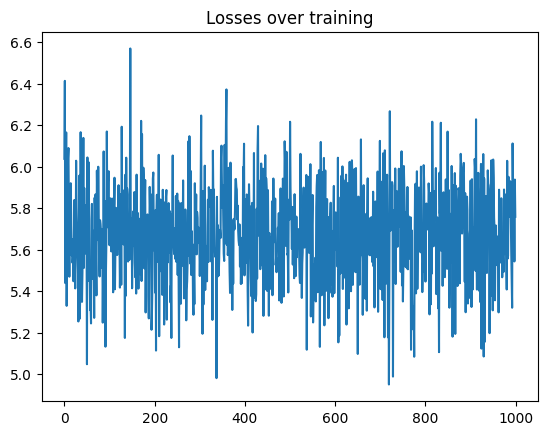

In [70]:
train_iterations(encoder, decoder, 100000, dataset, device, print_every=500)

Evaluation

In [75]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=MAX_LENGTH):
    # Eval 모드 설정
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_length = input_tensor.size(0)
        # Encoder의 hidden state 초기화
        encoder_hidden = encoder.init_hidden(device=device)

        # encoder_outputs는 Encoder를 통과한 문장의 출력
        # (max_length, hidden_size)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoder 에 입력 문자 주입 후 encoder_outputs 생성
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # Decoder의 첫 번째 입력으로 SOS_TOKEN 입력(SOS_TOKEN=0)
        decoder_input = torch.tensor([[0]], device=device)

        # Decoder의 첫 번째 hidden state는 Encoder의 마지막 hidden state 사용
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # 1개의 Decoder 입력 토큰을 통과
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Attention 시각화를 위한 tensor 저장
            decoder_attentions[di] = decoder_attention.data

            # 출력 토큰 예측
            topv, topi = decoder_output.data.topk(1)

            # EOS_TOKEN이면 종료
            if topi.item() == dataset.EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                # 출력 문장에 토큰 시퀀스(index)를 단어(word)로 변환한 후 저장
                decoded_words.append(dataset.wordvocab.index_to_word(topi.item()))

            # decoder_input은 다음 토큰 예측시 입력 값
            # decoder_input: (hidden_size,)
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    
def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    for i in range(n):
        # 랜덤 샘플링
        x, y = random.choice(dataset)
        # 입력 문장, 출력 문장 (Ground Truth)
        print('>', dataset.sequences_to_texts(x))
        print('=', dataset.sequences_to_texts(y))

        # 예측
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words)
        
        # 예측 문장 출력
        print('<', output_sentence)
        print('')

In [76]:
# 랜덤 샘플링 된 데이터 evaluate
evaluate_randomly(encoder, decoder, dataset, device)

> 원하지 않은 사람 은 퇴근 후 에 집 에 가서 휴식 을 취할 수 있도록 좀 보장 을 해 주었으면 하는 개인 적 인 바람 이 있습니다 . <EOS>
= 회식 에 대한 생각 이 있으신 가요 ? <EOS>
< 그래서 가 에 가 에 이 이 이 이 . <EOS>

> 저 는 제일 중요하다고 생각 하는 부분 이 갑 을 관계 가 없는 그런 관계 가 제일 중요하다고 생각 합니다 . <EOS>
= 어떤 연애 든 주도 권 을 잡는 사람 이 있으면 그 사람 의 의견 을 따를 수 밖에 없고 나중 에는 분명 한쪽 에서 참아 왔던 작은 소소한 부분 들 까지 큰 싸움 의 불씨 를 만들 수 있기 때문 에 저 는 갑 을 관계 가 없어야 된다는 걸 제일 중요하다고 생각 하고요 . <EOS>
< 그래서 가 는 가 에 이 이 이 . <EOS>

> 어 저 는 제 가 예전 에 이제 취업 준비 할 때 한 달 정도 영국 이 아 유럽 에 있었던 적 있어요 . <EOS>
= 여행 으로 근데 그때 한 달이 너무 좋았어서 스페인 을 간다 치면 은 최소 2 주 에서 길게는 한 달 정도 를 생각 했어서 뭐 한 달 살기 까지라고 하긴 조금 오번 거 같고 그냥 조금 스페인 의 군데 군데 도시 도시 를 조금 많이 다니면서 여행 겸 살기 정도 를 생각 을 했었는데 혹시 뭐 어 그 이전 에 장기로 여행 을 가 보신 적은 있으세요 ? <EOS>
< 그래서 가 는 가 에 이 이 이 . <EOS>

> 네 선물 같은 경우 에 감동 이라는 그러니까 감동 을 받은 선물 이 있고 그렇지 않은 선물 이 있잖아요 . <EOS>
= 물론 주는 사람 의 마음 을 어 느낄 수 있는 선물 이 되게 감동 적 이기는 한데 굳이 내 가 이 게 필요하나 필요하지 않는데 혹은 내 가 별로 이 거 가지 고 싶지 않다고 했고 있다고 생각 하는데 라는 선물 을 받게 되면 참 받는 사람 입장 에서도 난감하고 어 고마움 을 바로바로 표시 해야 할 때 어떻게 표시 를 해야 되는지 고민 이 되는 부분 이 있는 거 같아요 . <EOS>
< 그래서 가 는 가 에

attention 가중치 시각화

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

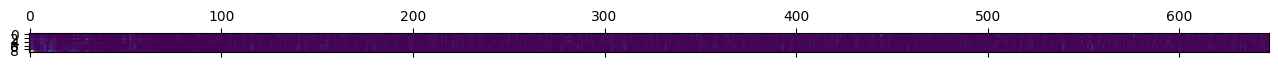

In [79]:
# Attention Weights를 활용한 시각화
output_words, attentions = evaluate(encoder, decoder, dataset[2][0].to(device), dataset, device)
plt.matshow(attentions.numpy())
plt.show()

In [74]:
# Attention 시각화를 위한 함수
def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    input_sentence = dataset.sequences_to_texts(input_sentence)
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence, output_words.split(), attentions)

In [71]:
dataset[2][0]

In [72]:
evaluate_and_show_attention(encoder, decoder, dataset[2][1], dataset, device)